# Import Necessary Libraries

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


# Download Close Price of SBIN, INFY from yfinance

In [2]:
tickers = ["SBIN.NS", "INFY.NS"]
data = yf.download(tickers, group_by="ticker", period="max")

# Select only 'Close'
close = data.xs('Close', axis=1, level=1).dropna()

# Display Close Price
print("Close Price of SBIN, INFY over time:\n")
display(close.head(2))


[*********************100%***********************]  2 of 2 completed

Close Price of SBIN, INFY over time:



Ticker,SBIN.NS,INFY.NS
Date,,
1996-01-01,11.965004,0.511998
1996-01-02,11.584164,0.509927


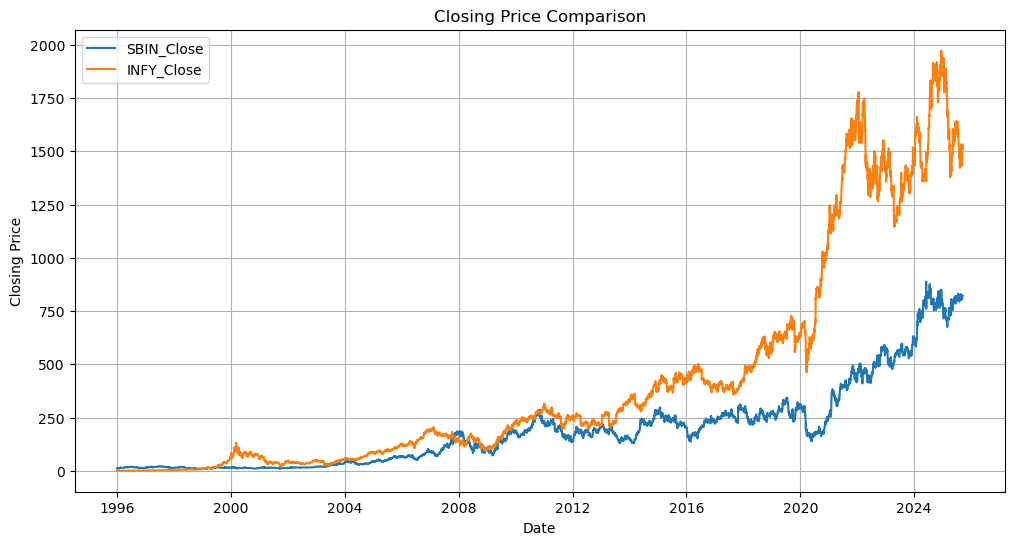

In [3]:
# Plot Close Price for both data
plt.figure(figsize=(12, 6))
plt.plot(close["SBIN.NS"].index,close["SBIN.NS"], label='SBIN_Close')
plt.plot(close["INFY.NS"].index,close["INFY.NS"], label='INFY_Close')
plt.title('Closing Price Comparison')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

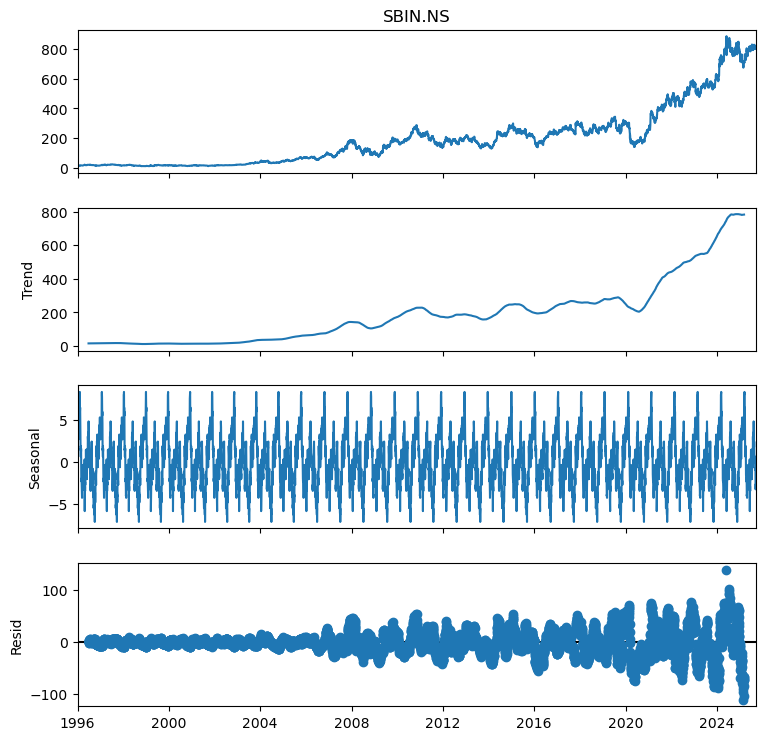

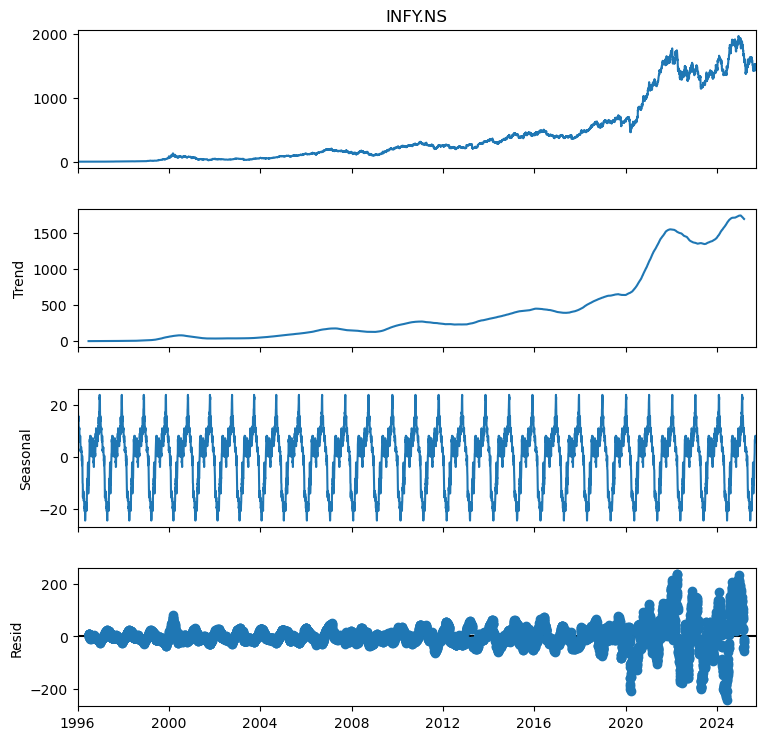

In [4]:
# Classical Decomposition of both data
decom_sbin = seasonal_decompose(close["SBIN.NS"], model="additive", period=252)
fig1 = decom_sbin.plot().set_size_inches(8, 8)
plt.show()

decom_infy = seasonal_decompose(close["INFY.NS"], model="additive", period=252)
fig2 = decom_infy.plot().set_size_inches(8, 8)
plt.show()

In [5]:
# Define a function for the Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', 'Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("Conclusion: Reject the null hypothesis (H0), the series is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.\n")

In [6]:
# Perform ADF test on Close Price
adf_test(close["SBIN.NS"], title="SBI_Close")
adf_test(close["INFY.NS"], title="INFY_Close")

Augmented Dickey-Fuller Test: SBI_Close
ADF Statistic: 1.2191613595661486
p-value: 0.9961156328046668
Lags Used: 34
Number of Observations Used: 7423
Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.

Augmented Dickey-Fuller Test: INFY_Close
ADF Statistic: 0.2735748103194726
p-value: 0.976099097239765
Lags Used: 31
Number of Observations Used: 7426
Conclusion: Fail to reject the null hypothesis (H0), the series is not stationary.



In [7]:
# Define a function for the Kwiatkowski-Phillips-Schmidt-Shin test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    statistic, p_value, n_lags, critical_values = kpss(series.dropna())
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Number of Lags Used: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value}')

    if p_value <= 0.05:
        print("Conclusion: Reject the null hypothesis (H0), the series is not stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis (H0), the series is stationary./n")

In [8]:
kpss_test(close["SBIN.NS"], title="SBI_Close")
kpss_test(close["INFY.NS"], title="INFY_Close")

KPSS Test: SBI_Close
KPSS Statistic: 10.353202593723001
p-value: 0.01
Number of Lags Used: 53
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject the null hypothesis (H0), the series is not stationary.
KPSS Test: INFY_Close
KPSS Statistic: 10.268829331795486
p-value: 0.01
Number of Lags Used: 53
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: Reject the null hypothesis (H0), the series is not stationary.


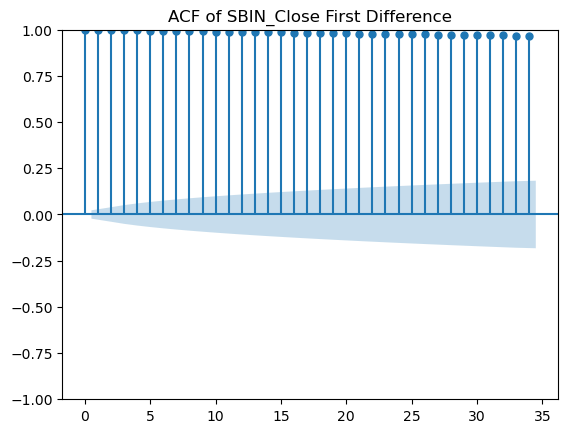

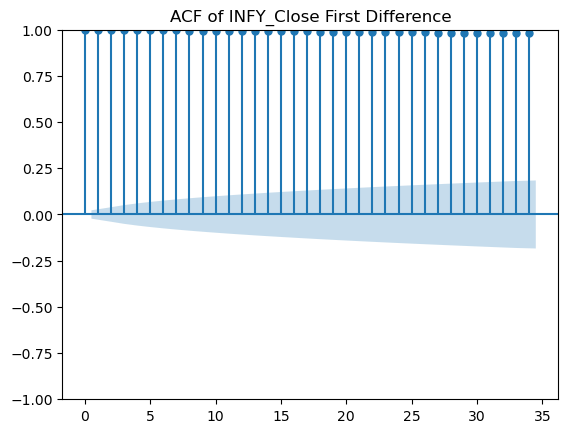

In [9]:
# Plot ACF for SBIN_Close_diff
plot_acf(close["SBIN.NS"], lags=34, title='ACF of SBIN_Close First Difference')
plt.show()

# Plot ACF for INFY_Close_diff
plot_acf(close["INFY.NS"], lags=34, title='ACF of INFY_Close First Difference')
plt.show()

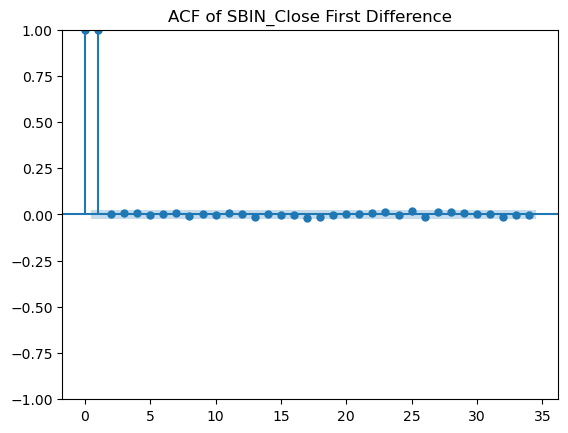

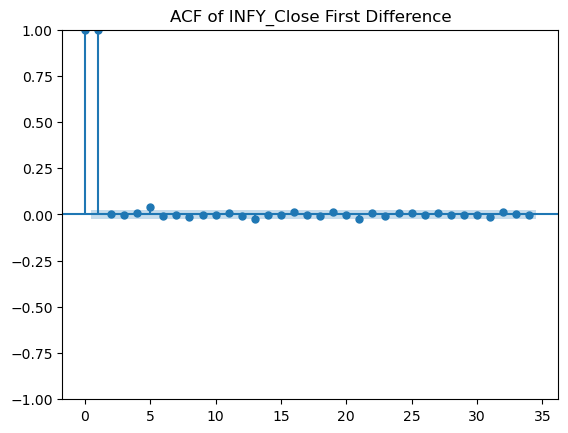

In [10]:
# Plot PACF for SBIN_Close_diff
plot_pacf(close["SBIN.NS"], lags=34, title='ACF of SBIN_Close First Difference')
plt.show()

# Plot PACF for INFY_Close_diff
plot_pacf(close["INFY.NS"], lags=34, title='ACF of INFY_Close First Difference')
plt.show()

In [ ]:
# Estimate the number of differences required for SBIN_Close
n_diffs_sbin = ndiffs(close['SBIN.NS'].dropna(), test='adf')
print(f"Estimated number of differences required for SBIN_Close: {n_diffs_sbin}")

# Eastimate the number of differences required for INFY.NS
n_diffs_infy = ndiffs(close['INFY.NS'].dropna(), test='adf')
print(f"Estimated number of differences required for INFY_Close: {n_diffs_infy}") # Try: test='kpss', 'pp' also

Estimated number of differences required for SBIN_Close: 1
Estimated number of differences required for INFY_Close: 1


In [12]:
# Perform train-test split
train_size = int(len(close) * 0.95) # 95% for training
train_data, test_data = close[0:train_size], close[train_size:]

print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (7085, 2)
Test data shape: (373, 2)


In [13]:
def best_arima_model(time_series):
  print("Searching for the best ARIMA model...")
  best_model = pm.auto_arima(time_series,
                              start_p=1,
                              start_q=1,
                              max_p=7,              # Maximum value for p to test
                              max_q=7,              # determine d automatically
                              start_P = 0,
                              m = 3,
                              test='adf',           # ADF test to find order of differencing
                              seasonal=False,       # No seasonality
                              trace=True,
                              error_action='ignore',
                              D = 1,
                              suppress_warnings=True,
                              stepwise=True)         # Stepwise algorithm to speed up the search

  print("\n==== Best Model Summary ===")
  print(best_model.summary())

  return best_model

In [14]:
# Best sbi model
best_sbi_model = best_arima_model(train_data['SBIN.NS'])

Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=40374.238, Time=1.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40385.335, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=40372.574, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=40372.382, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40387.520, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=40374.200, Time=1.72 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=40376.372, Time=1.95 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=40374.205, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 7.442 seconds

==== Best Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7085
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -20183.191
Date:                Fri, 12 Sep 2025   

In [15]:
# Best infy model
best_infy_model = best_arima_model(train_data['INFY.NS'])

Searching for the best ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51137.707, Time=2.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=51163.857, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51154.785, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51153.867, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=51166.088, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=51147.800, Time=1.76 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51147.762, Time=2.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51145.876, Time=1.74 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=51145.851, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51140.501, Time=6.76 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=51139.782, Time=0.82 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 18.421 seconds

==== Best Model Summary ===
                               SARIMAX Results                             

In [16]:
# Forecast on test_data
forecast_sbin, sbin_conf_int = best_sbi_model.predict(n_periods=len(test_data), return_conf_int=True)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_data['SBIN.NS'], forecast_sbin))
print(f"RMSE: {rmse:.4f}")

# Compute MAPE
mape = mean_absolute_percentage_error(test_data['SBIN.NS'], forecast_sbin) * 100
print(f"MAPE: {mape:.2f}%")

# Print Confidence interval
conf_int = pd.DataFrame(sbin_conf_int, index=test_data.index, columns=['Lower', 'Upper'])
print(conf_int.head(2))

RMSE: 53.8107
MAPE: 5.70%
                 Lower       Upper
Date                              
2024-03-13  723.774175  740.157375
2024-03-14  720.211909  743.922869


In [17]:
# Forecast on test_data
forecast_infy, infy_conf_int = best_infy_model.predict(n_periods=len(test_data), return_conf_int=True)

# Compute rmse
rmse = np.sqrt(mean_squared_error(test_data['INFY.NS'], forecast_infy))
print(f"RMSE: {rmse:.4f}")

# Compute MAPE
mape = mean_absolute_percentage_error(test_data['INFY.NS'], forecast_infy) * 100
print(f"MAPE: {mape:.2f}%")

# Print Confidence interval
conf_int = pd.DataFrame(infy_conf_int, index=test_data.index, columns=['Lower', 'Upper'])
print(conf_int.head(2))

RMSE: 193.9741
MAPE: 9.90%
                  Lower        Upper
Date                                
2024-03-13  1533.712476  1568.734212
2024-03-14  1525.894837  1576.381621


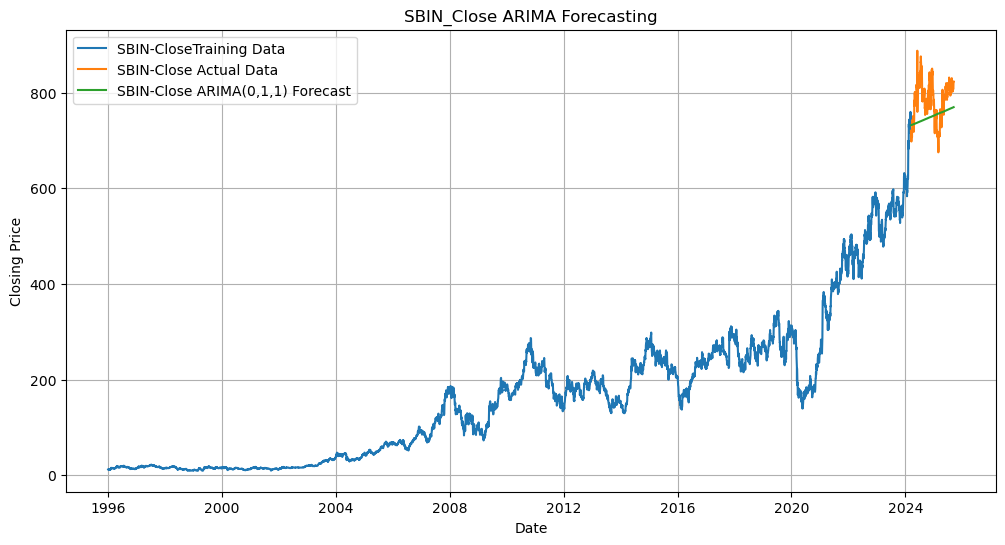

In [18]:
# Plot ARIMA forecast for SBIN_Close
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['SBIN.NS'], label='SBIN-CloseTraining Data')
plt.plot(test_data.index, test_data['SBIN.NS'], label='SBIN-Close Actual Data')
plt.plot(test_data.index, forecast_sbin, label=f'SBIN-Close ARIMA(0,1,1) Forecast')
plt.title('SBIN_Close ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

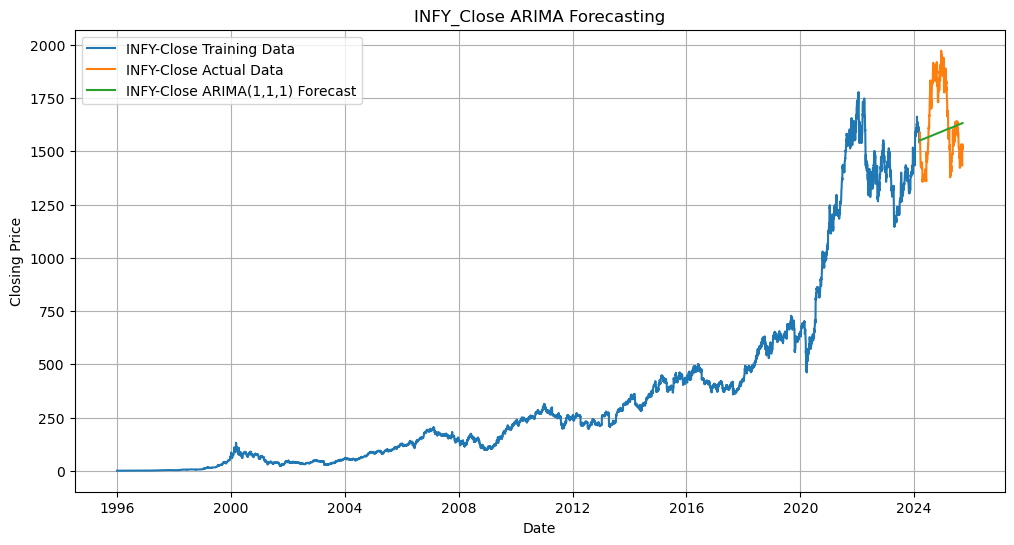

In [19]:
# Plot ARIMA forecast for INFY_Close
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['INFY.NS'], label='INFY-Close Training Data')
plt.plot(test_data.index, test_data['INFY.NS'], label='INFY-Close Actual Data')
plt.plot(test_data.index, forecast_infy, label=f'INFY-Close ARIMA(1,1,1) Forecast')
plt.title('INFY_Close ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

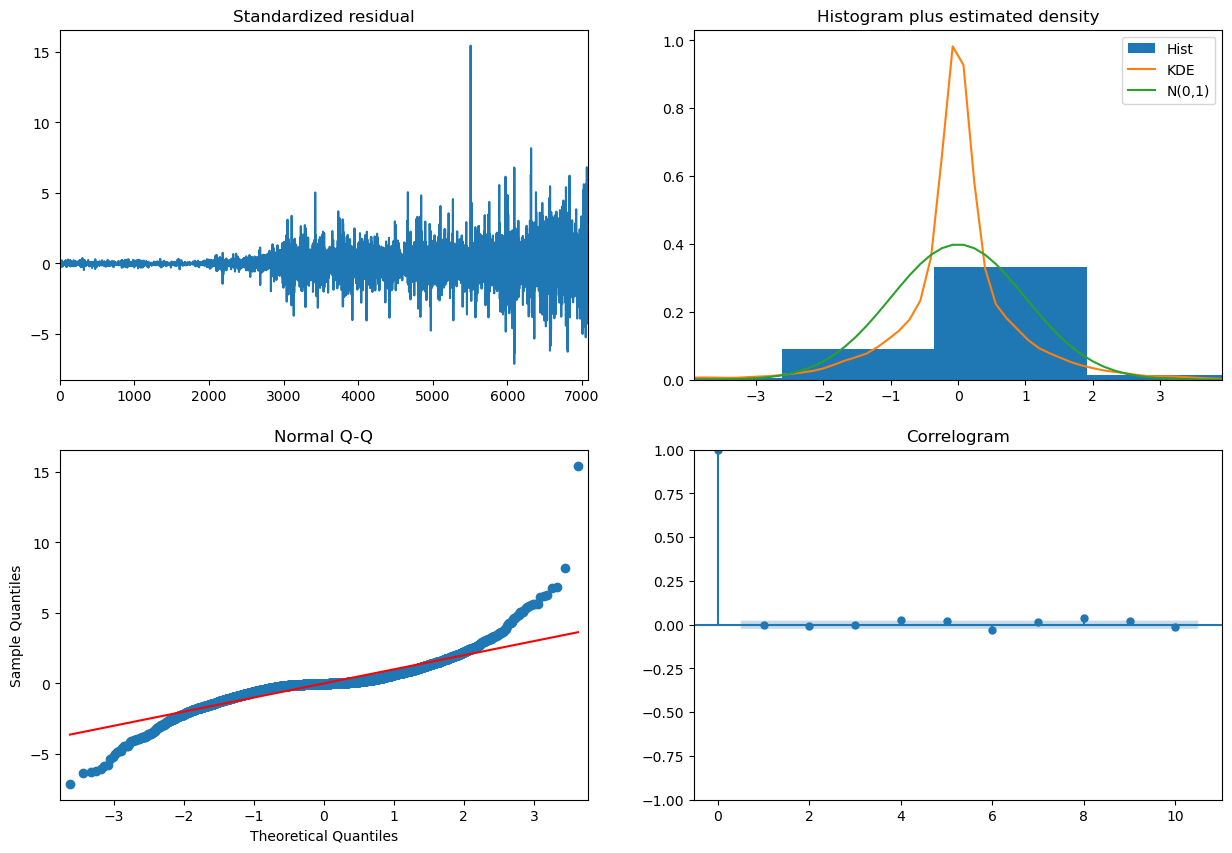

In [20]:
# ARIMA Model Diagnostics for SBIN close
best_sbi_model.plot_diagnostics(figsize=(15, 10))
plt.show()

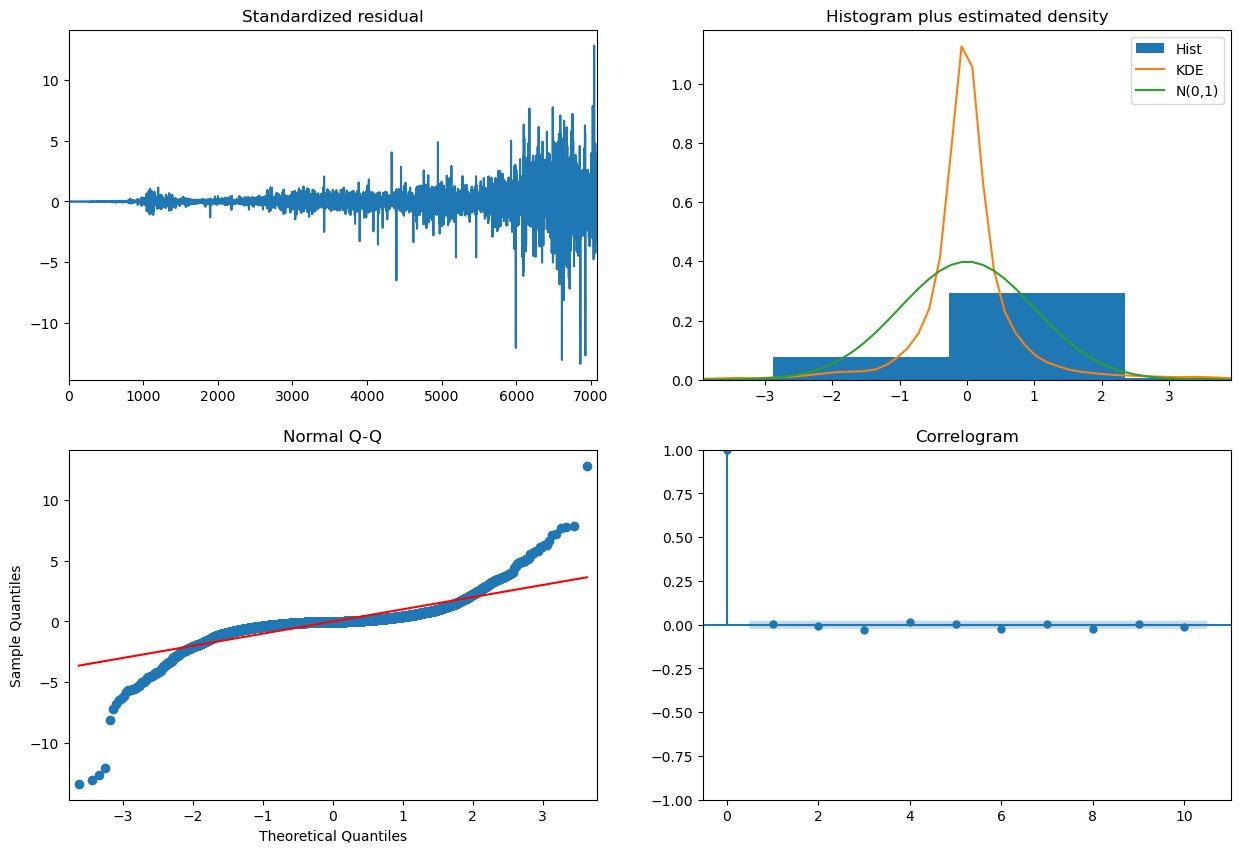

In [21]:
# ARIMA Model Diagnostics for INFY close
best_infy_model.plot_diagnostics(figsize=(15, 10))
plt.show()

# Calculate Daily Log Returns of Both Data

In [22]:
# Compute daily log returns in %
returns = np.log(close/close.shift(1)).dropna() * 100
print("\nLog Returns of SBIN, INFY over time:\n")
display(returns.head(2))


Log Returns of SBIN, INFY over time:



Ticker,SBIN.NS,INFY.NS
Date,,
1996-01-02,-3.234709,-0.405260
1996-01-03,-2.702548,0.674609


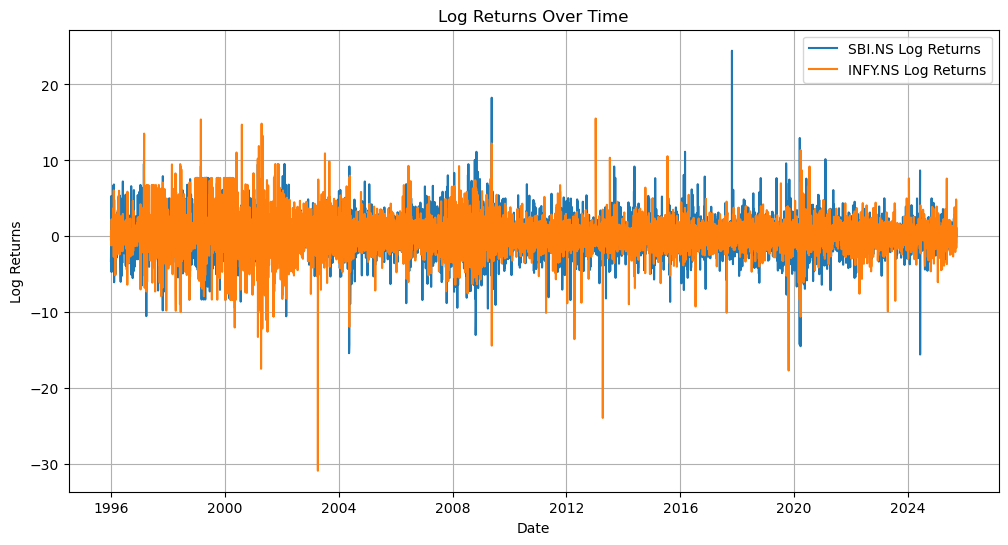

In [23]:
# Plot Log Returns
plt.figure(figsize=(12, 6))
plt.plot(returns["SBIN.NS"].index, returns["SBIN.NS"], label='SBI.NS Log Returns')
plt.plot(returns["INFY.NS"].index, returns["INFY.NS"], label='INFY.NS Log Returns')
plt.title('Log Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Perform ADF test on Log Returns
adf_test(returns["SBIN.NS"], title="SBI-Returns")
adf_test(returns["INFY.NS"], title="INFY-Returns")

Augmented Dickey-Fuller Test: SBI-Returns
ADF Statistic: -23.567715798719053
p-value: 0.0
Lags Used: 11
Number of Observations Used: 7445
Conclusion: Reject the null hypothesis (H0), the series is stationary.
Augmented Dickey-Fuller Test: INFY-Returns
ADF Statistic: -14.056301415384182
p-value: 3.112901770281877e-26
Lags Used: 32
Number of Observations Used: 7424
Conclusion: Reject the null hypothesis (H0), the series is stationary.


In [25]:
def arch_test(series, nlags=None):
  series = series.dropna()
  test_stat, p_value, f_stat, f_p_value = het_arch(series, nlags=nlags)

  # Print nicely
  print(f"ARCH Test Statistic: {test_stat:.4f}")
  print(f"ARCH Test p-value: {p_value:.4f}")
  print(f"ARCH Test F-statistic: {f_stat:.4f}")
  print(f"ARCH Test F-Test p-value: {f_p_value:.4f}")

In [26]:
print("Arch Test for SBIN log-return:")
arch_test(returns["SBIN.NS"], nlags=21)
print("\nArch Test for INFY log-return:")
arch_test(returns["INFY.NS"], nlags=21)

Arch Test for SBIN log-return:
ARCH Test Statistic: 498.8984
ARCH Test p-value: 0.0000
ARCH Test F-statistic: 25.3903
ARCH Test F-Test p-value: 0.0000

Arch Test for INFY log-return:
ARCH Test Statistic: 518.4929
ARCH Test p-value: 0.0000
ARCH Test F-statistic: 26.4622
ARCH Test F-Test p-value: 0.0000


- The low p-value suggests that there are statistically significant ARCH effects present in the both log returns.

In [27]:
# Perform train-test split
train_size = int(len(returns) * 0.95) # 95% for training
train_data, test_data = returns[0:train_size], returns[train_size:]

print('Train data shape:', train_data.shape)
print('Test data shape:', test_data.shape)

Train data shape: (7084, 2)
Test data shape: (373, 2)


In [28]:
def best_garch_model(series, p_max=7, q_max=7, dist='t'):
  series = series.dropna()
  best_model = None
  best_aic = np.inf
  best_order = None

  for p in range(1, p_max + 1):
    for q in range(1, q_max + 1):
      try:
        model = arch_model(series, vol='Garch', p=p, q=q, dist=dist)
        fit = model.fit(disp='off')
        if fit.aic < best_aic:
          best_aic = fit.aic
          best_model = fit
          best_order = (p, q)
      except Exception as e:
        print(f"Skipped p={p}, q={q} due to error: {e}")
        continue

  print(f"\n Best GARCH Model: GARCH{best_order} with AIC = {best_aic:.4f}")
  print("\nModel Coefficients (t-stats and p-values):")
  print(best_model.summary())

  return best_model, best_order

In [29]:
def rolling_forecast(train, test, best_order, dist='t'):
  history = train.tolist()
  predictions = []

  for t in range(len(test)):
    model = arch_model(history, vol='Garch', p=best_order[0], q=best_order[1], dist=dist)
    fit = model.fit(disp='off')
    pred = fit.forecast(horizon=1)
    predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    history.append(test[t])

  return pd.Series(predictions, index=test.index)

In [30]:
def actual_rolling_std(train, test, window=20):
  extended_test = pd.concat([train.iloc[-window:], test])
  rolling_std = extended_test.rolling(window).std()
  return rolling_std[-len(test):]

In [31]:
def compute_rmse(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

In [32]:
def plot_volatility(test_index, actual, predicted, best_order):
  plt.figure(figsize=(14, 7))
  plt.plot(test_index, actual, label='Actual Rolling Std Dev')
  plt.plot(test_index, predicted, label='Predicted Volatility', color='red')
  plt.title(f'Actual Rolling Std Dev vs Predicted Volatility (GARCH{best_order})')
  plt.xlabel('Date')
  plt.ylabel('Volatility / Std Dev')
  plt.legend()
  plt.show()

# Best GARCH Model For SBIN Log-Returns


 Best GARCH Model: GARCH(1, 2) with AIC = 30773.3989

Model Coefficients (t-stats and p-values):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      SBIN.NS   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -15380.7
Distribution:      Standardized Student's t   AIC:                           30773.4
Method:                  Maximum Likelihood   BIC:                           30814.6
                                              No. Observations:                 7084
Date:                      Fri, Sep 12 2025   Df Residuals:                     7083
Time:                              23:40:05   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0

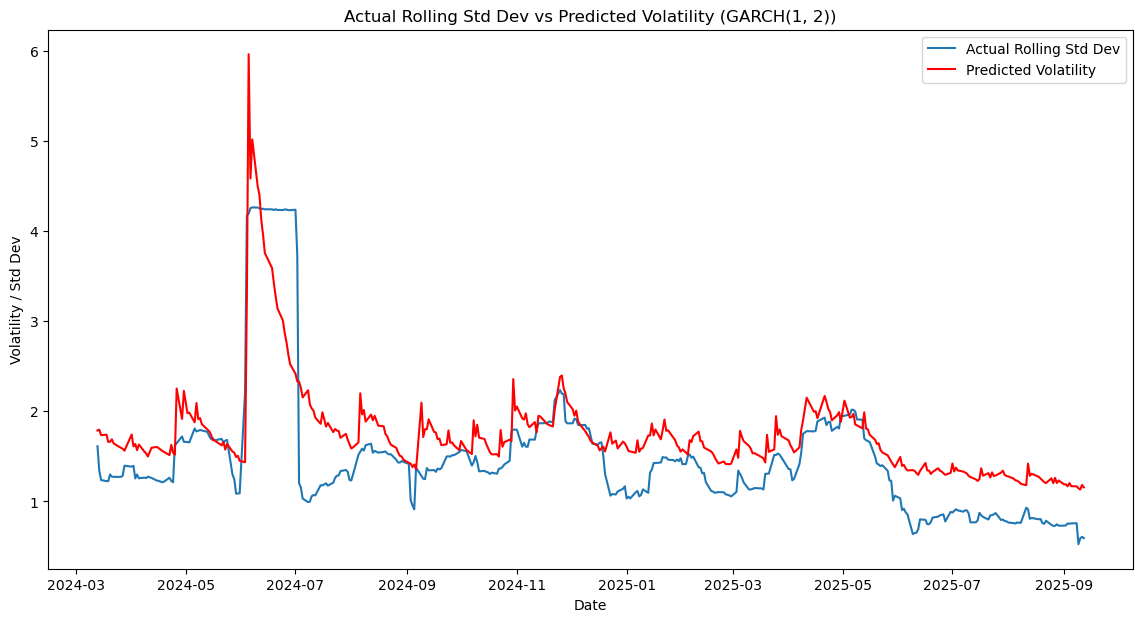

In [33]:
train=train_data['SBIN.NS']
test=test_data['SBIN.NS']
# Find best model
best_model_sbin, best_order_sbin = best_garch_model(train)

# Rolling forecast
rolling_pred = rolling_forecast(train, test, best_order_sbin)

# Actual rolling std
rolling_std_actual = actual_rolling_std(train, test, window=20)

# RMSE
rmse = compute_rmse(rolling_std_actual, rolling_pred)
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred, best_order_sbin)

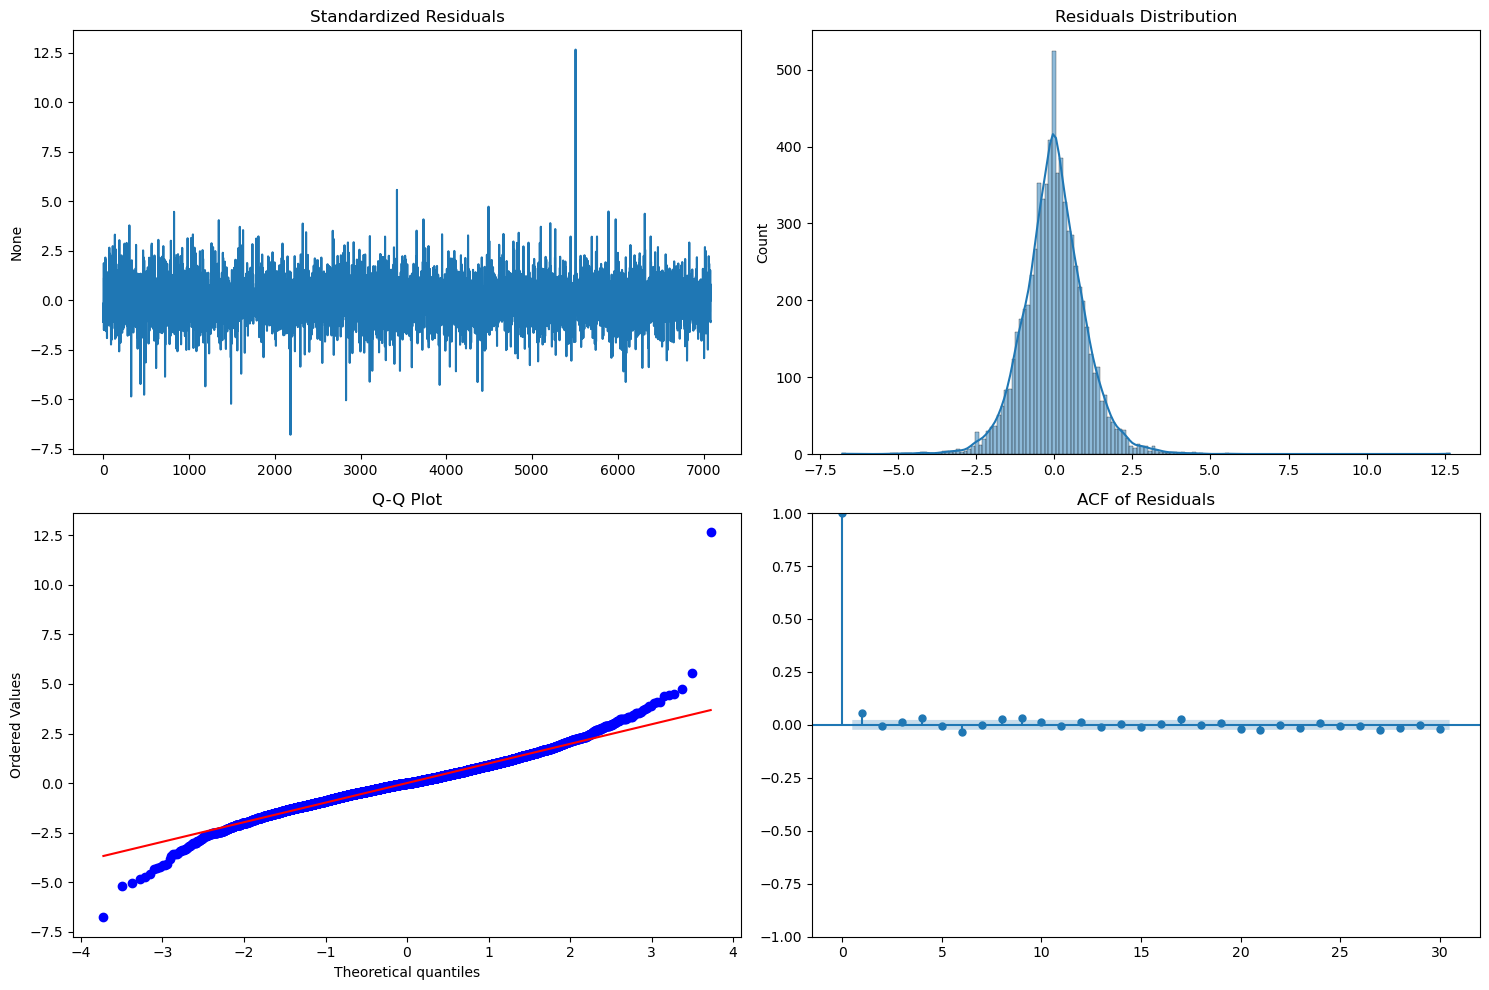

In [34]:
# Calculate Residuals
residuals = best_model_sbin.resid / best_model_sbin.conditional_volatility
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

# Best GARCH Model For INFY Log-Returns


 Best GARCH Model: GARCH(1, 5) with AIC = 29477.6792

Model Coefficients (t-stats and p-values):
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      INFY.NS   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -14729.8
Distribution:      Standardized Student's t   AIC:                           29477.7
Method:                  Maximum Likelihood   BIC:                           29539.5
                                              No. Observations:                 7084
Date:                      Fri, Sep 12 2025   Df Residuals:                     7083
Time:                              23:41:02   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0

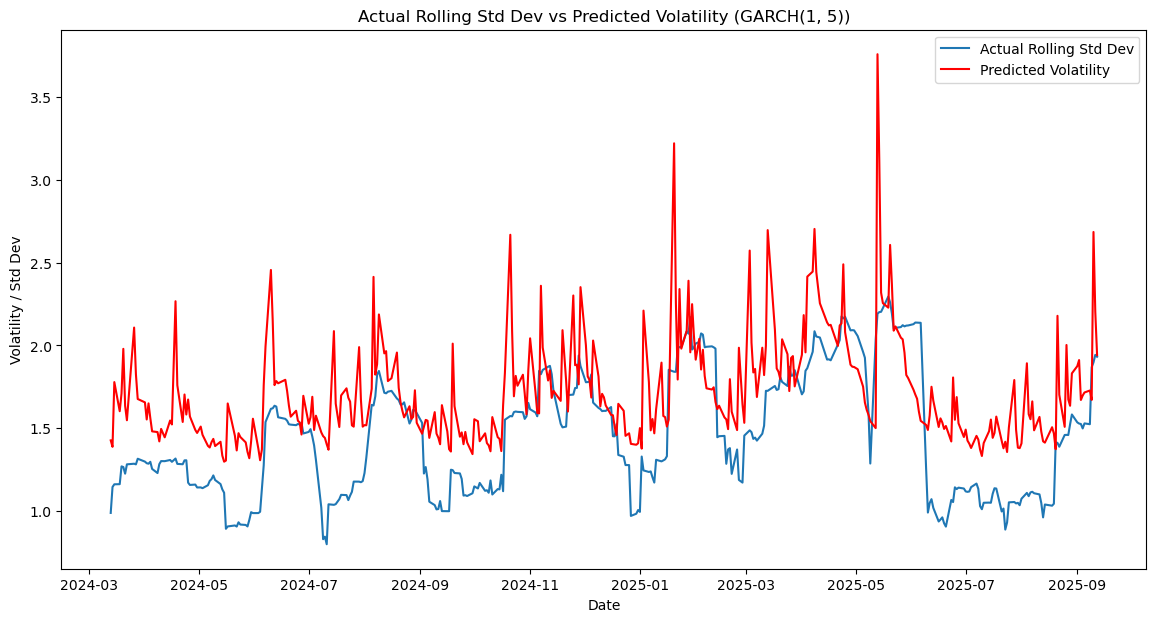

In [35]:
train=train_data['INFY.NS']
test=test_data['INFY.NS']

# Find best model
best_model_infy, best_order_infy = best_garch_model(train)

# Rolling forecast
rolling_pred = rolling_forecast(train, test, best_order_infy)

# Actual rolling std
rolling_std_actual = actual_rolling_std(train, test, window=20)

# RMSE
rmse = compute_rmse(rolling_std_actual, rolling_pred)
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred, best_order_infy)

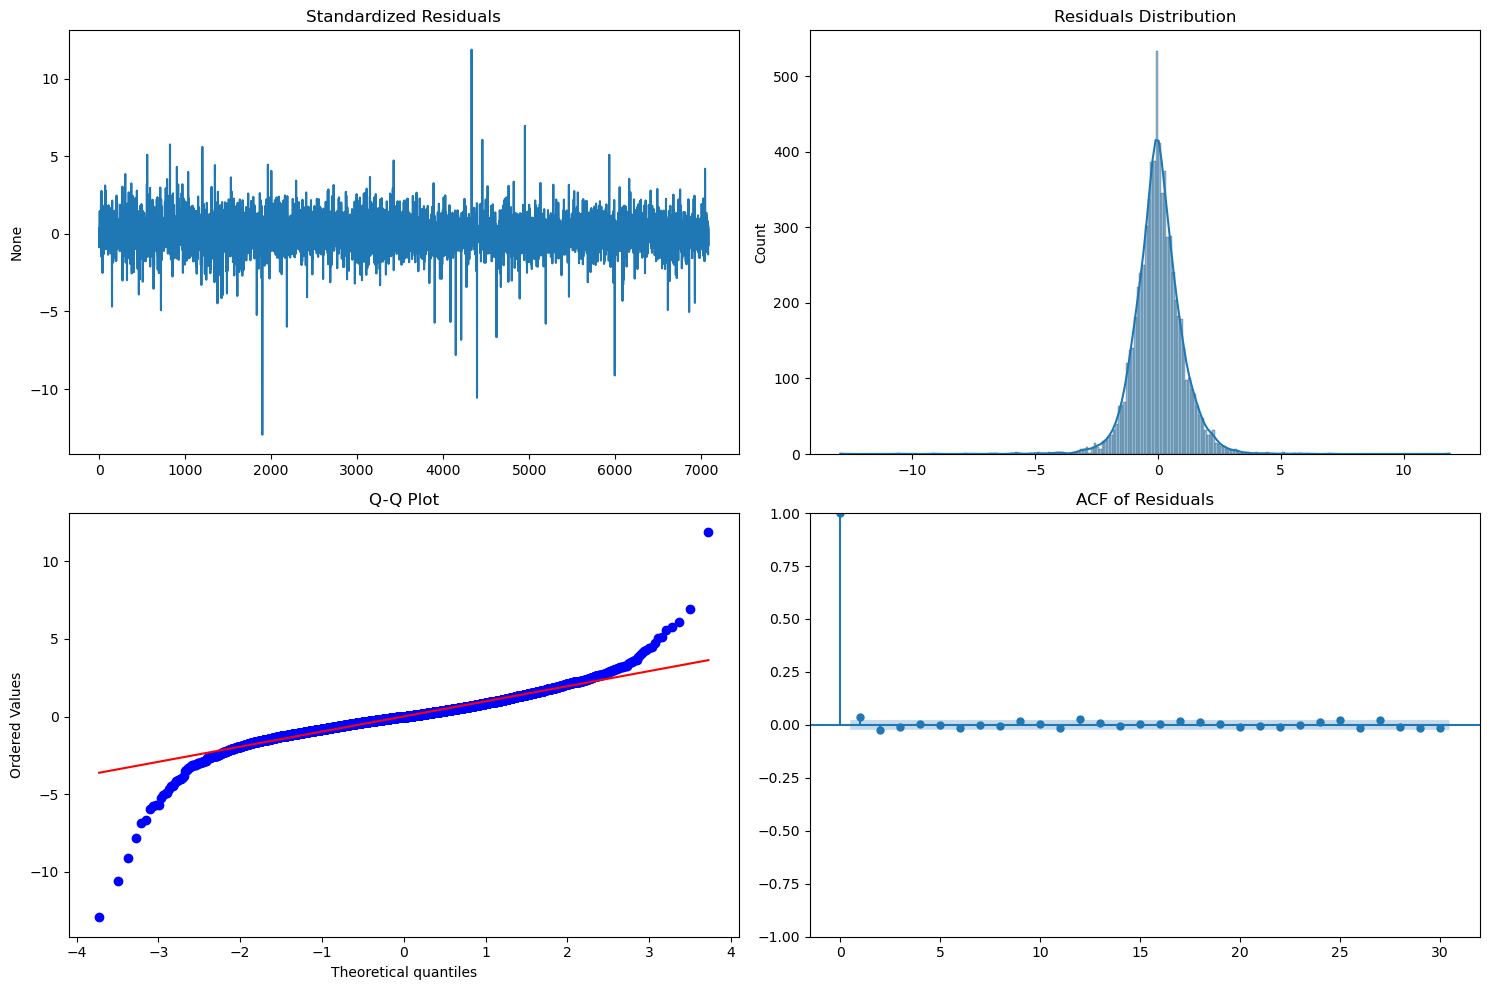

In [36]:
residuals = best_model_infy.resid / best_model_infy.conditional_volatility
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

# GJR-Garch Model with Students-T


## GJR-Garch(1, 1, 1) Model For SBIN Log-Returns

In [37]:
train = train_data["SBIN.NS"] # For INFY.NS change SBIN.NS to INFY.NS
test = test_data["SBIN.NS"]

In [38]:
from arch.univariate import ConstantMean, GARCH, StudentsT
am = ConstantMean(train)
am.volatility = GARCH(1, 1, 1)
am.distribution = StudentsT()
result = am.fit(disp="off")
print(result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      SBIN.NS   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -15380.2
Distribution:      Standardized Student's t   AIC:                           30772.4
Method:                  Maximum Likelihood   BIC:                           30813.6
                                              No. Observations:                 7084
Date:                      Fri, Sep 12 2025   Df Residuals:                     7083
Time:                              23:42:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

In [39]:
# AIC and BIC
print("AIC:", result.aic)
print("BIC:", result.bic)


AIC: 30772.42169124828
BIC: 30813.615255241697


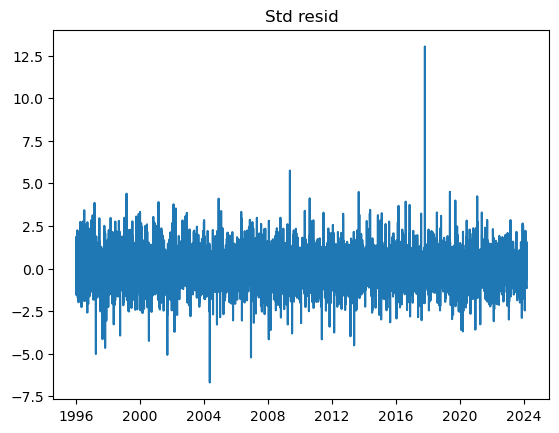

In [40]:
# Standardized residuals
std_resid = result.std_resid.dropna()

# Plotting
plt.plot(std_resid); plt.title('Std resid')
plt.show()

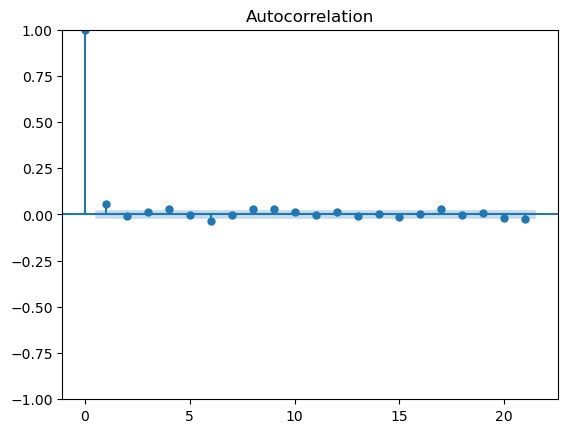

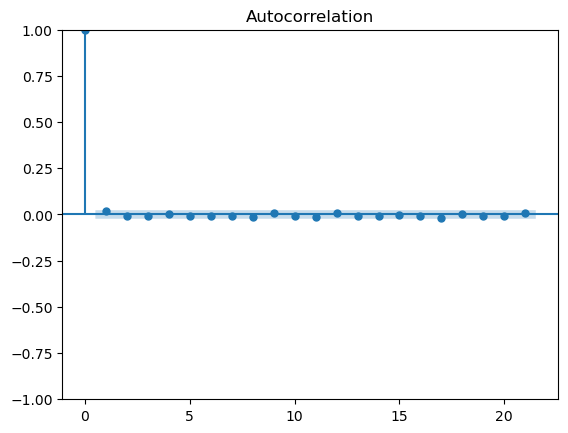

In [41]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(std_resid, lags=21)
plt.show()
sm.graphics.tsa.plot_acf(std_resid**2, lags=21)
plt.show()

In [42]:
# Ljung–Box on residuals
lb_resid = sm.stats.acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
print("Ljung–Box on residuals:")
print(lb_resid)

# Ljung–Box on squared residuals (volatility clustering)
lb_resid2 = sm.stats.acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)
print("\nLjung–Box on squared residuals:")
print(lb_resid2)


Ljung–Box on residuals:
      lb_stat     lb_pvalue
10  55.102652  3.021648e-08
20  68.115410  3.687738e-07

Ljung–Box on squared residuals:
      lb_stat  lb_pvalue
10   8.133868   0.615763
20  14.548234   0.801648


In [43]:
lm_stat, lm_pvalue, _, _ = het_arch(std_resid, nlags=21)
print('ARCH LM p-value:', lm_pvalue)

ARCH LM p-value: 0.8120734381292837


In [44]:
def gjr_rolling_forecast(train, test):
  history = train.tolist()
  predictions = []

  for t in range(len(test)):
    model = arch_model(history, vol='Garch', p=1, o=1, q=1, dist='studentst', mean='Constant')
    fit = model.fit(disp='off')
    pred = fit.forecast(horizon=1)
    predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    history.append(test[t])

  return pd.Series(predictions, index=test.index)

In [45]:
def gjr_actual_rolling_std(train, test, window=40):
  extended_test = pd.concat([train.iloc[-window:], test])
  rolling_std = extended_test.rolling(window).std()
  return rolling_std[-len(test):]

In [46]:
def plot_volatility(test_index, actual, predicted):
  plt.figure(figsize=(14, 7))
  plt.plot(test_index, actual, label='Actual Rolling Std Dev')
  plt.plot(test_index, predicted, label='Predicted Volatility', color='red')
  plt.title(f'Actual Rolling Std Dev vs Predicted Volatility')
  plt.xlabel('Date')
  plt.ylabel('Volatility / Std Dev')
  plt.legend()
  plt.show()

RMSE: 0.4746


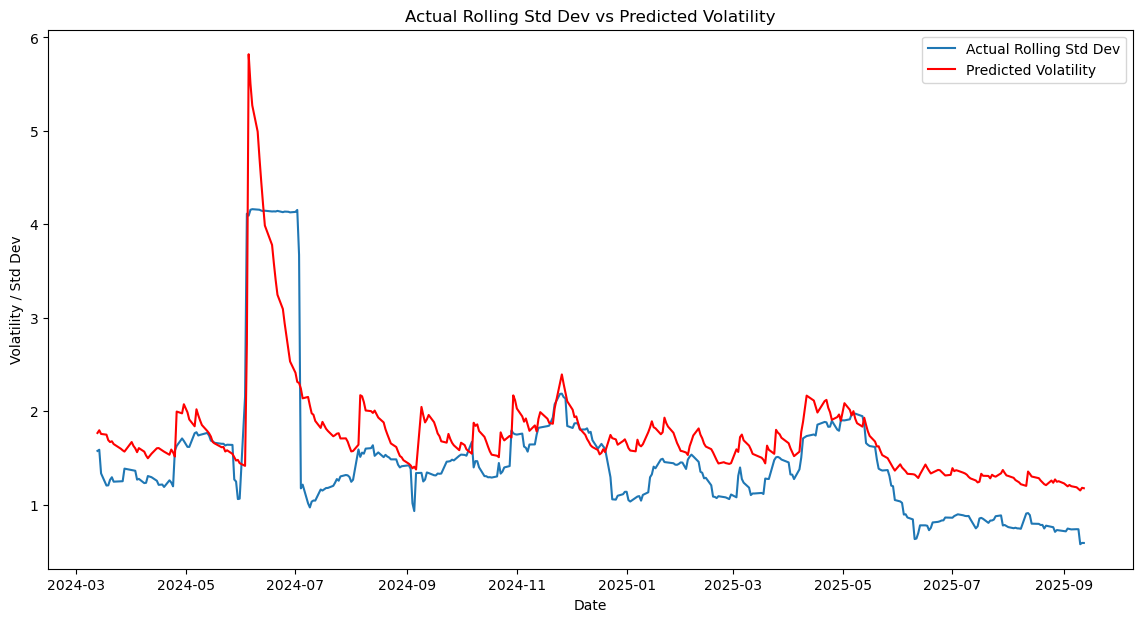

In [47]:
# Rolling forecast
rolling_pred = gjr_rolling_forecast(train, test)

# Actual rolling std
rolling_std_actual = gjr_actual_rolling_std(train, test, window=21)

# RMSE
rmse = np.sqrt(mean_squared_error(rolling_std_actual, rolling_pred))
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred)

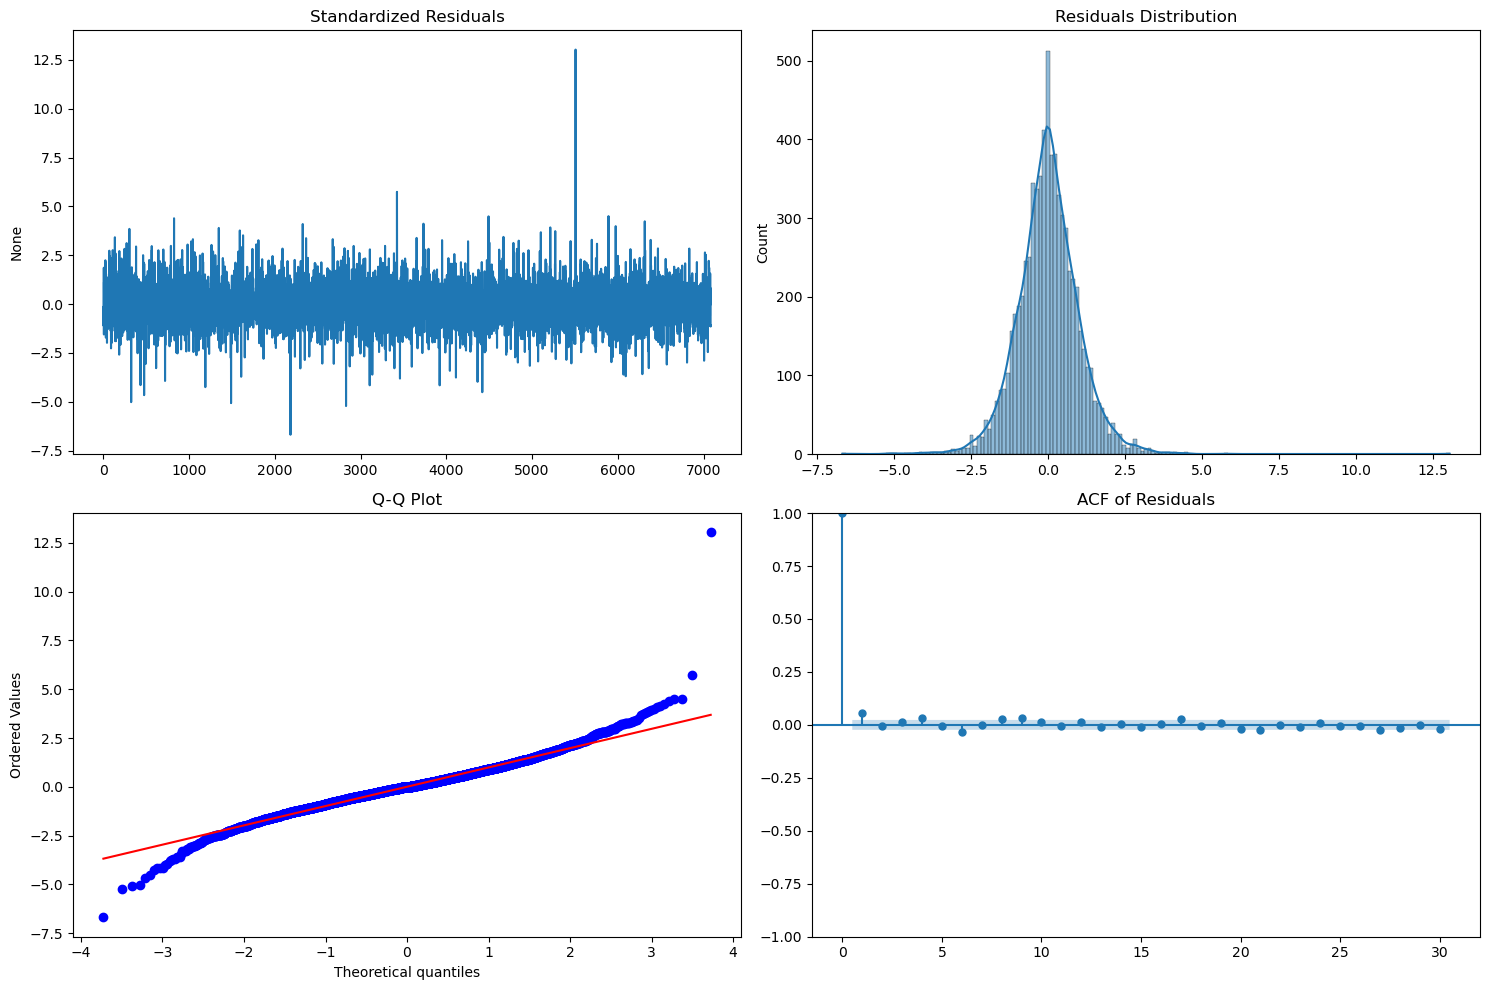

In [48]:
residuals = result.resid / result.conditional_volatility
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

## GJR-Garch(1, 1, 1) Model For INFY Log-Returns

In [97]:
train = train_data["INFY.NS"]
test = test_data["INFY.NS"]

In [98]:
from arch.univariate import ConstantMean, GARCH, StudentsT
am = ConstantMean(train)
am.volatility = GARCH(1, 1, 1)
am.distribution = StudentsT()
result = am.fit(disp="off")
print(result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      INFY.NS   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -14748.3
Distribution:      Standardized Student's t   AIC:                           29508.7
Method:                  Maximum Likelihood   BIC:                           29549.9
                                              No. Observations:                 7084
Date:                      Sat, Sep 13 2025   Df Residuals:                     7083
Time:                              00:30:49   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [99]:
# AIC and BIC
print("AIC:", result.aic)
print("BIC:", result.bic)

AIC: 29508.681052876207
BIC: 29549.874616869623


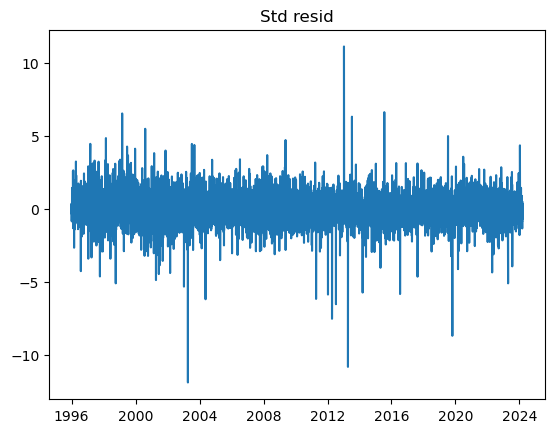

In [100]:
# Standardized residuals
std_resid = result.std_resid.dropna()

# Plotting
plt.plot(std_resid); plt.title('Std resid')
plt.show()

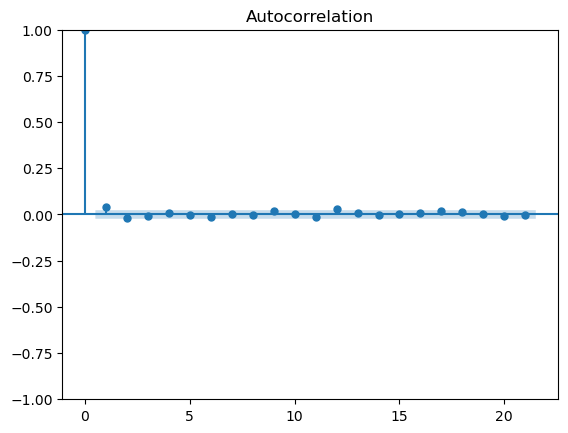

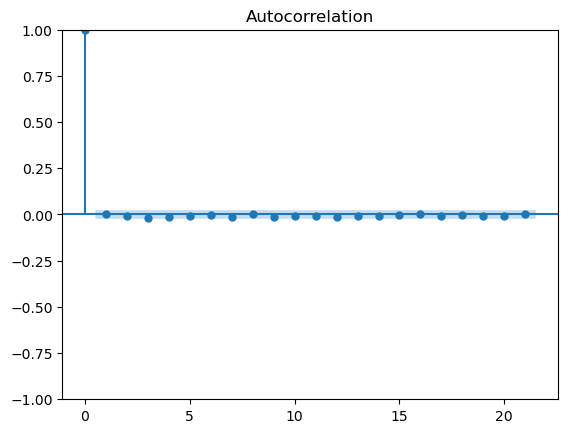

In [101]:
sm.graphics.tsa.plot_acf(std_resid, lags=21)
plt.show()
sm.graphics.tsa.plot_acf(std_resid**2, lags=21)
plt.show()

In [102]:
# Ljung–Box on residuals
lb_resid = sm.stats.acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
print("Ljung–Box on residuals:")
print(lb_resid)

# Ljung–Box on squared residuals (volatility clustering)
lb_resid2 = sm.stats.acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)
print("\nLjung–Box on squared residuals:")
print(lb_resid2)

lm_stat, lm_pvalue, _, _ = het_arch(std_resid, nlags=21)
print('\nARCH LM p-value:', lm_pvalue)


Ljung–Box on residuals:
      lb_stat  lb_pvalue
10  21.215202   0.019642
20  34.055708   0.025750

Ljung–Box on squared residuals:
      lb_stat  lb_pvalue
10   7.960256   0.632719
20  12.107908   0.912312

ARCH LM p-value: 0.8951512570675989


RMSE: 0.4364


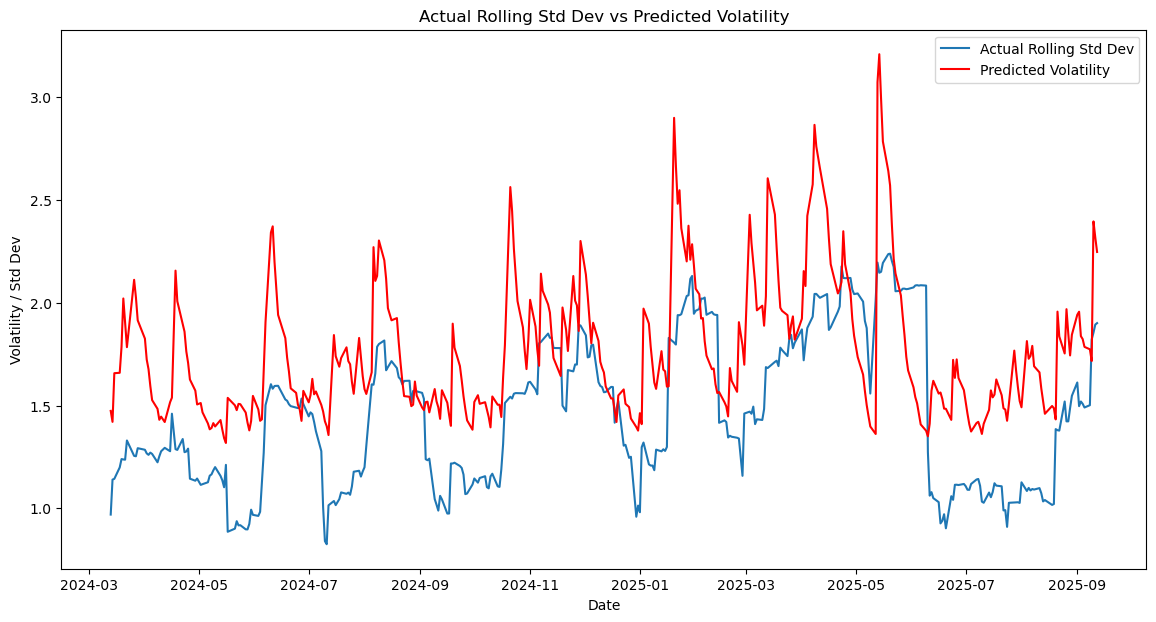

In [103]:
# Rolling forecast
rolling_pred = gjr_rolling_forecast(train, test)

# Actual rolling std
rolling_std_actual = gjr_actual_rolling_std(train, test, window=21)

# RMSE
rmse = np.sqrt(mean_squared_error(rolling_std_actual, rolling_pred))
print(f"RMSE: {rmse:.4f}")

# Plot
plot_volatility(test.index, rolling_std_actual, rolling_pred)

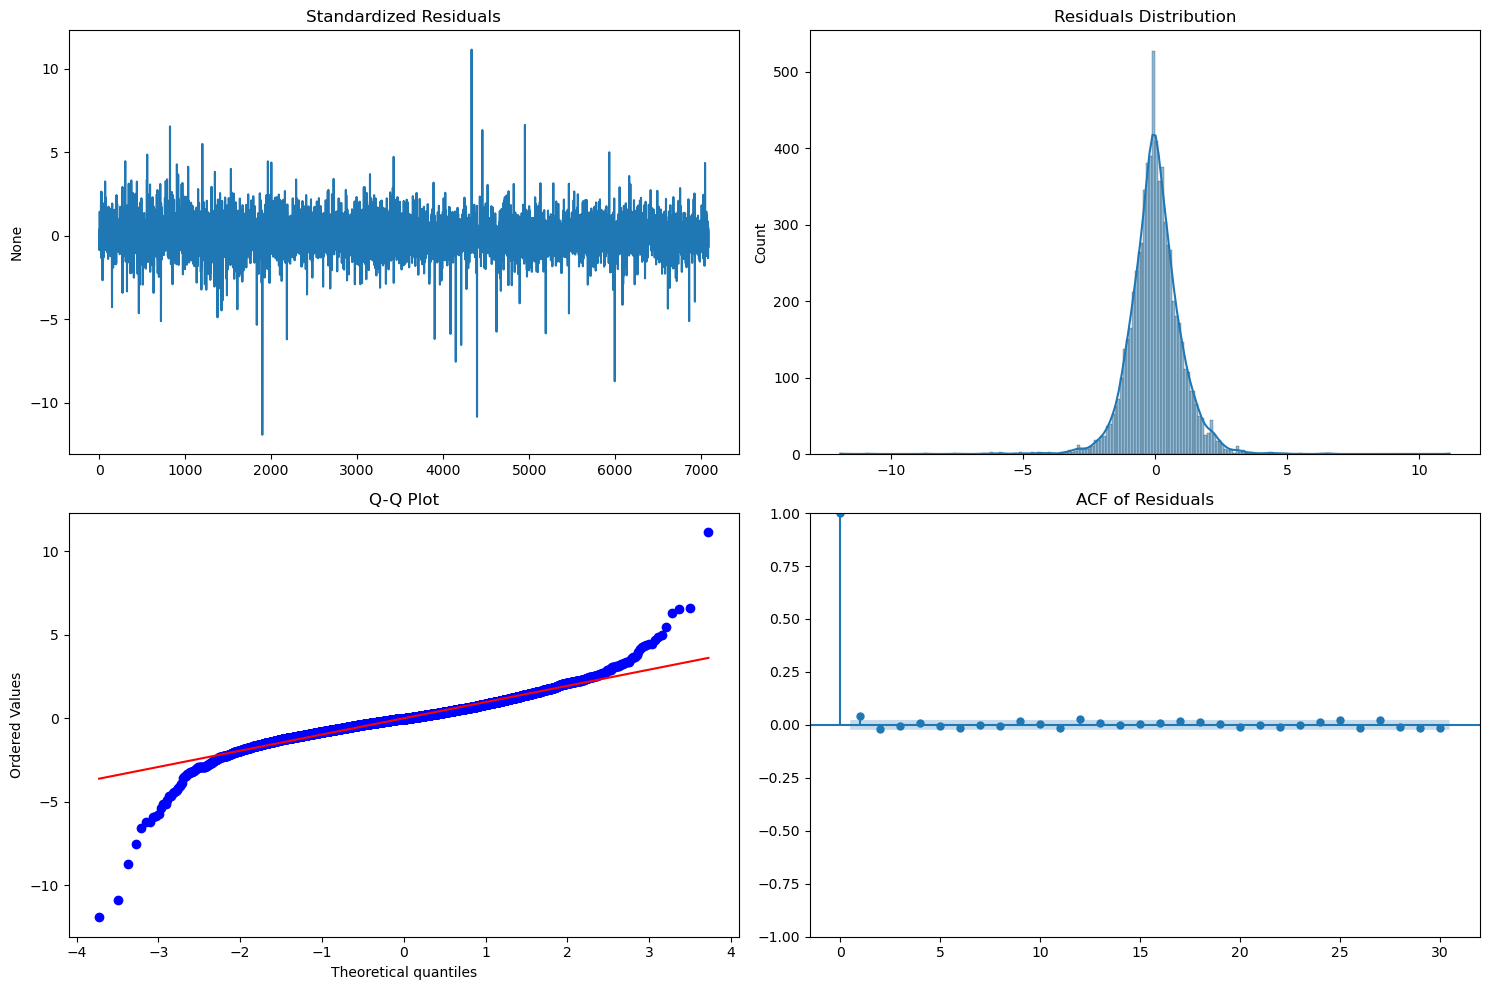

In [104]:
residuals = result.resid / result.conditional_volatility
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Residuals plot
sns.lineplot(x=range(len(residuals)), y=residuals, ax=ax[0, 0])
ax[0, 0].set_title("Standardized Residuals")

# Histogram & KDE
sns.histplot(residuals, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Distribution")

#  Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])
ax[1, 0].set_title("Q-Q Plot")

#  ACF Plot
plot_acf(residuals, lags=30, ax=ax[1, 1])
ax[1, 1].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()

# EVT (POT) thresholding and GPD fit on SBI.NS

In [50]:
from pyextremes import EVA
from pyextremes import plot_mean_residual_life, plot_parameter_stability
from scipy.stats import kstest, anderson, anderson, genpareto, t

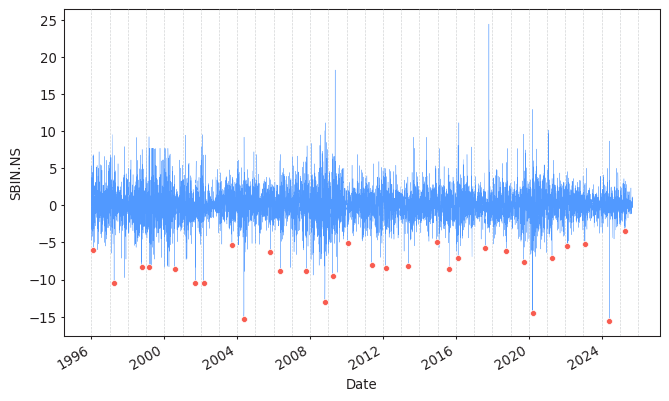

In [51]:
# Select the log returns for SBIN.NS
r = returns['SBIN.NS']
model = EVA(data=r)

# Block Maxima method
model.get_extremes('BM', extremes_type='low')

# Plot the extracted extreme values
model.plot_extremes()
plt.show()

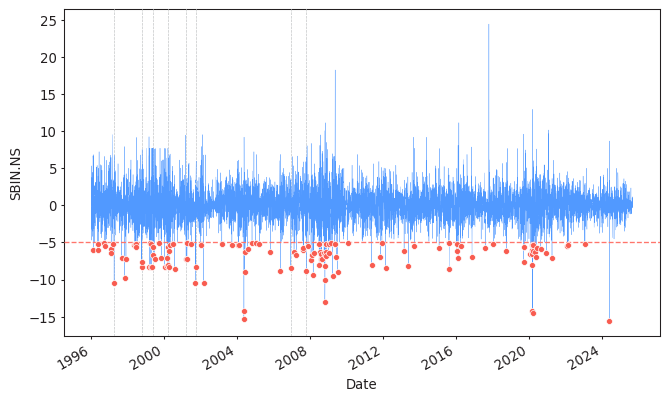

In [52]:
# PIC Over Threshold
model.get_extremes("POT", extremes_type='low', threshold=-5)
model.plot_extremes(show_clusters=True)
plt.show()

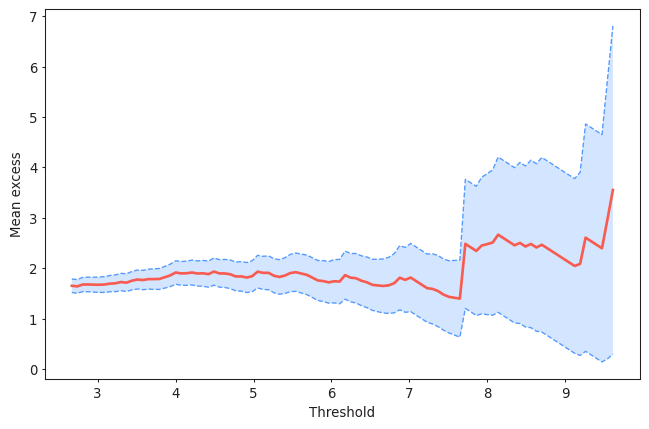

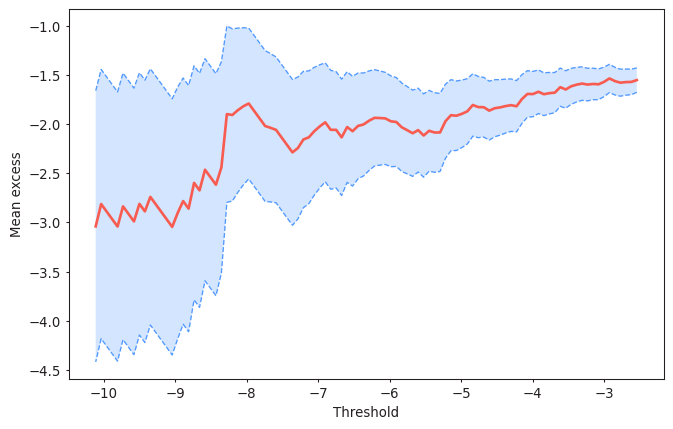

In [53]:
# Plot Mean Residual Life
plot_mean_residual_life(r, alpha=0.95, extremes_type='high')
plot_mean_residual_life(r, alpha=0.95, extremes_type='low')
plt.show()

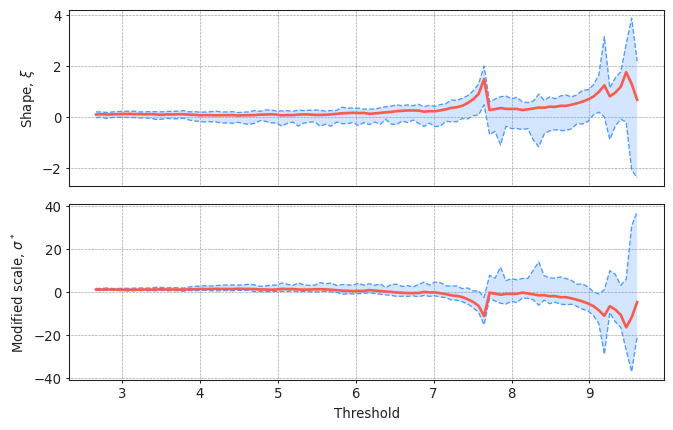

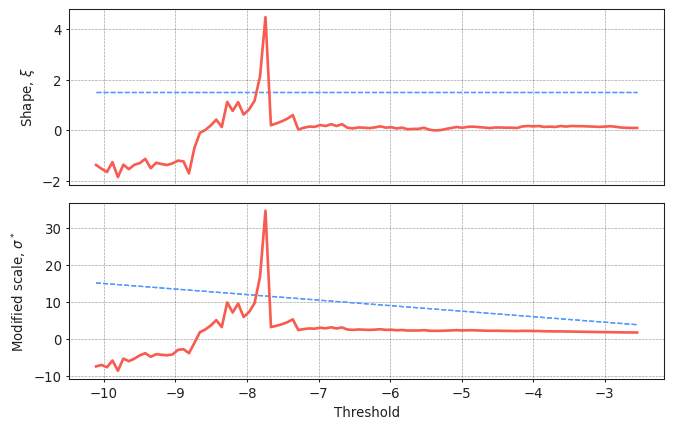

In [54]:
plot_parameter_stability(r, alpha=0.95, extremes_type="high")
plot_parameter_stability(r, alpha=0.95, extremes_type="low")
plt.show()

In [68]:
upper_threshold = 6.8
lower_threshold = -7.1

### Upper Tail:

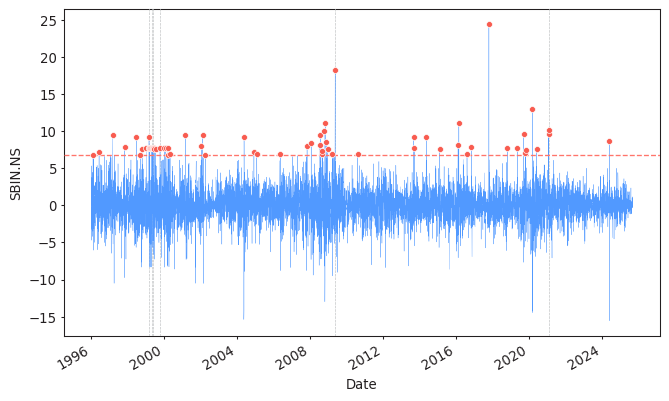

In [69]:
model1 = EVA(data=r)
model1.get_extremes("POT", extremes_type='high', threshold=upper_threshold)
model1.plot_extremes(show_clusters=True)
plt.show()

In [70]:
# Extract exceedances
exceedances_upper = r[r > upper_threshold] - upper_threshold
print("Number of Upper exceedances:", len(exceedances_upper))

# Fit GPD to exceedances
shape_upper, loc_upper, scale_upper = genpareto.fit(exceedances_upper, floc=0)

print("Fitted GPD parameters:")
print(f"Upper: shape={shape_upper:.4f}, loc={loc_upper:.4f}, scale={scale_upper:.4f}")

Number of Upper exceedances: 73
Fitted GPD parameters:
Upper: shape=0.2347, loc=0.0000, scale=1.2698


In [71]:
model1.fit_model(distribution= "genpareto")
summary = model1.get_summary(
    return_period=[ 5, 10, 25, 50, 100, 250, 500],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value   lower ci   upper ci
return period                                    
5.0               11.033562   9.563328  12.837318
10.0              12.808337  10.113639  16.066329
25.0              15.683417  10.747507  22.807935
50.0              18.343651  11.052627  30.303452
100.0             21.510465  11.310440  41.275181
250.0             26.640608  11.605625  63.246238
500.0             31.387388  11.784304  88.848916


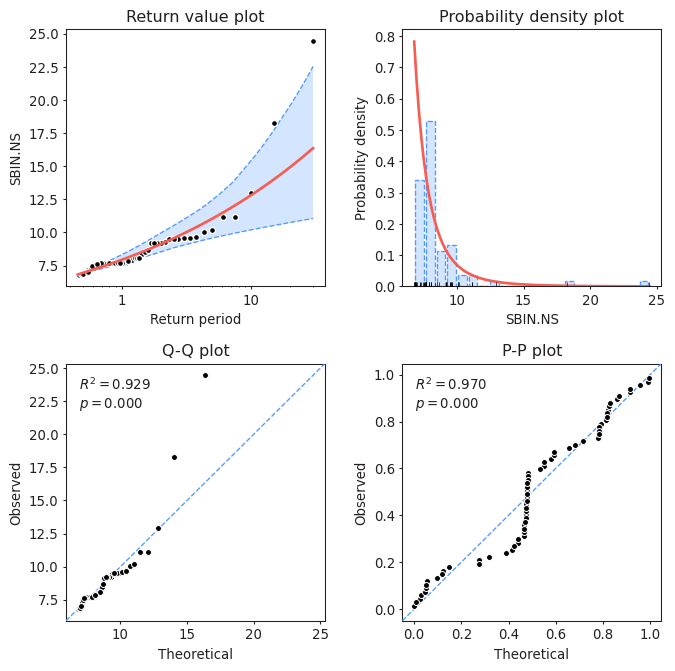

In [72]:
model1.plot_diagnostic(alpha=0.95)
plt.show()

### Lower Tail:

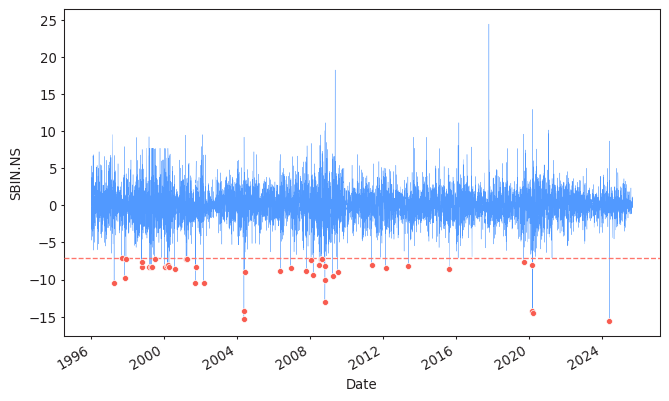

In [73]:
model2 = EVA(data=r)
model2.get_extremes("POT", extremes_type='low', threshold=lower_threshold)
model2.plot_extremes(show_clusters=True)
plt.show()

In [74]:
# Extract exceedances
exceedances_lower = lower_threshold - r[r < lower_threshold]
print("Number of Lower exceedances:", len(exceedances_lower))

# Fit GPD to exceedances
shape_lower, loc_lower, scale_lower = genpareto.fit(exceedances_lower, floc=0)
print("Fitted GPD parameters:")
print(f"Lower: shape={shape_lower:.4f}, loc={loc_lower:.4f}, scale={scale_lower:.4f}")

Number of Lower exceedances: 45
Fitted GPD parameters:
Lower: shape=0.0930, loc=0.0000, scale=1.9219


In [75]:
model2.fit_model(distribution= "genpareto")
summary = model2.get_summary(
    return_period=[ 5, 10, 25, 50, 100, 250, 500],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value   lower ci   upper ci
return period                                    
5.0              -11.326967 -10.045259 -12.696948
10.0             -13.033496 -11.158379 -14.629466
25.0             -15.543824 -12.603847 -18.345814
50.0             -17.655872 -13.728093 -22.767962
100.0            -19.971028 -14.765379 -28.558467
250.0            -23.376657 -16.099475 -38.948887
500.0            -26.241960 -16.863689 -50.270198


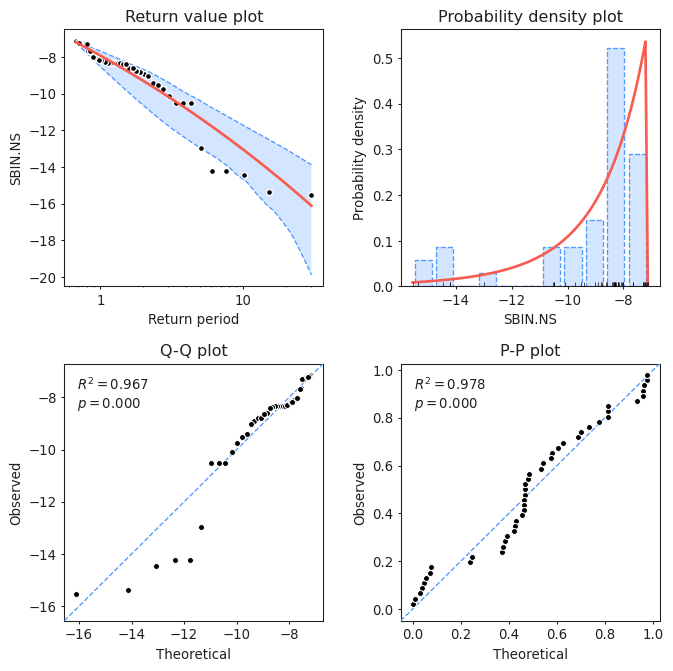

In [119]:
model2.plot_diagnostic(alpha=0.95)
plt.show()

### Goodness-of-fit tests:
- Perform Kolmogorov-Smirnov (KS) and Anderson-Darling (AD) tests for both high and low tails to assess the fit of the GPD.

In [76]:
# KS test
ks_statistic, p_value = kstest(exceedances_upper, 'genpareto', args=(shape_upper, 0, scale_upper))
print(f"KS test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# AD test
u = genpareto.cdf(exceedances_upper, c=shape_upper, loc=0, scale=scale_upper)
# Transform to exponential(1)
exp_data = -np.log(u)
# Anderson–Darling test for exponentiality
ad_result = anderson(exp_data, dist='expon')

print("Anderson–Darling test for GPD fit (via PIT)")
print(f"Statistic: {ad_result.statistic:.4f}")
print("Critical values:", ad_result.critical_values)
print("Significance levels:", ad_result.significance_level)

KS test: statistic=0.1873, p-value=0.0102
Anderson–Darling test for GPD fit (via PIT)
Statistic: 2.3386
Critical values: [0.914 1.069 1.33  1.593 1.941]
Significance levels: [15.  10.   5.   2.5  1. ]


In [78]:
# KS test
ks_statistic, p_value = kstest(exceedances_lower, 'genpareto', args=(shape_lower, 0, scale_lower))
print(f"KS test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# AD test
u = genpareto.cdf(exceedances_lower, c=shape_lower, loc=0, scale=scale_lower)
# Transform to exponential(1)
exp_data = -np.log(u)
# Anderson–Darling test for exponentiality
ad_result = anderson(exp_data, dist='expon')

print("Anderson–Darling test for GPD fit (via PIT)")
print(f"Statistic: {ad_result.statistic:.4f}")
print("Critical values:", ad_result.critical_values)
print("Significance levels:", ad_result.significance_level)

KS test: statistic=0.1513, p-value=0.2299
Anderson–Darling test for GPD fit (via PIT)
Statistic: 0.9298
Critical values: [0.91  1.064 1.323 1.585 1.931]
Significance levels: [15.  10.   5.   2.5  1. ]


# Global PIT (full marginal CDF)

### Smooth CDF: t/Skew-t body and GPD tails with a logistic splice over a short transition band.

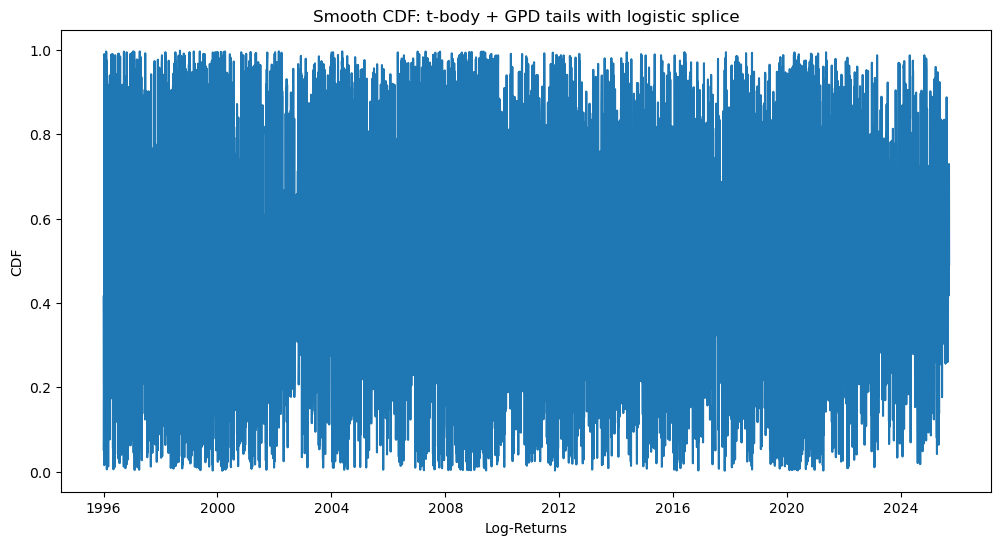

In [85]:
# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Logistic splice
def logistic_splice(x, x0, k):
    return 1 / (1 + np.exp(-(x-x0)/k))

# Smooth CDF
def smooth_cdf(x):
    F = np.zeros_like(x, dtype=float)

    # Lower tail
    mask_lower = x <= lower_threshold
    F[mask_lower] = (1 - logistic_splice(x[mask_lower], lower_threshold, k)) * genpareto.cdf(lower_threshold - x[mask_lower], shape_lower, loc_lower, scale_lower) \
                + logistic_splice(x[mask_lower], lower_threshold, k) * t.cdf(x[mask_lower], df_body, loc_body, scale_body)

    # Body
    mask_body = (x > lower_threshold) & (x < upper_threshold)
    F[mask_body] = t.cdf(x[mask_body], df_body, loc_body, scale_body)

    # Upper tail
    mask_upper = x >= upper_threshold
    F[mask_upper] = (1 - logistic_splice(x[mask_upper], upper_threshold, k)) * t.cdf(x[mask_upper], df_body, loc_body, scale_body) \
                + logistic_splice(x[mask_upper], upper_threshold, k) * (1 - genpareto.cdf(x[mask_upper] - upper_threshold, shape_upper, loc_upper, scale_upper))

    return F

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


### PIT values and Histogram

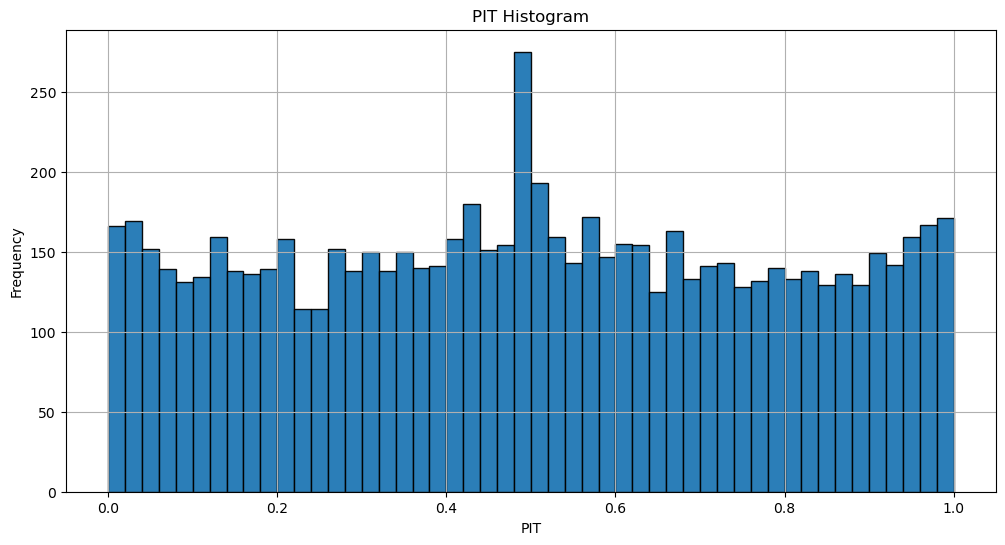

In [86]:
pit_values = smooth_cdf(r.values)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

#### KS Test

In [87]:
ks_stat, p_value = kstest(pit_values, 'uniform')
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0174, p-value: 0.0220


# EVT (POT) thresholding and GPD fit on SBI.NS

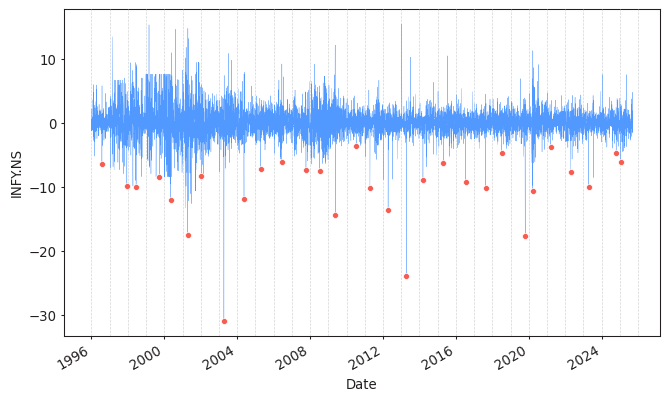

In [107]:
# Select the log returns for SBIN.NS
r = returns['INFY.NS']
model = EVA(data=r)

# Block Maxima method
model.get_extremes('BM', extremes_type='low')

# Plot the extracted extreme values
model.plot_extremes()
plt.show()

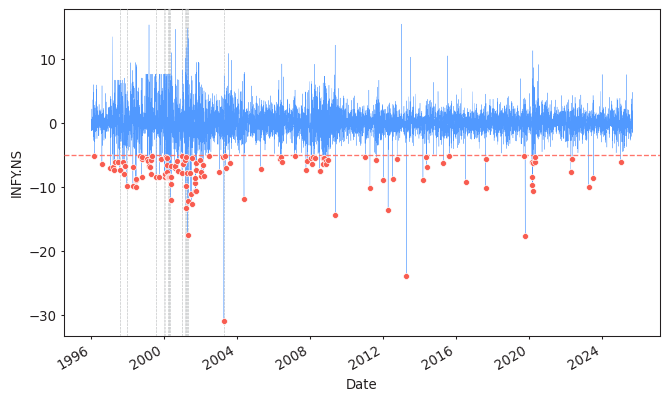

In [108]:
# PIC Over Threshold
model.get_extremes("POT", extremes_type='low', threshold=-5)
model.plot_extremes(show_clusters=True)
plt.show()

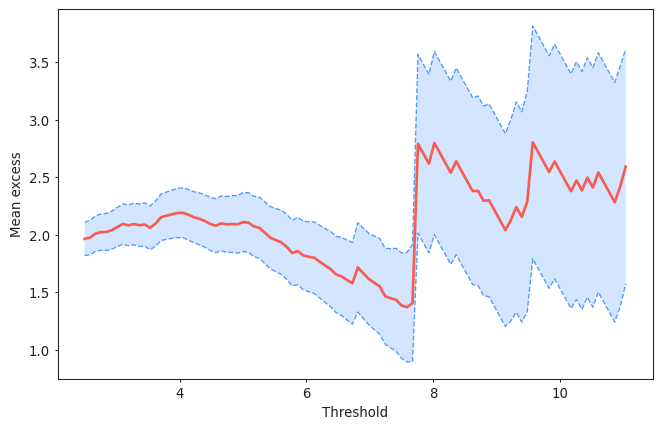

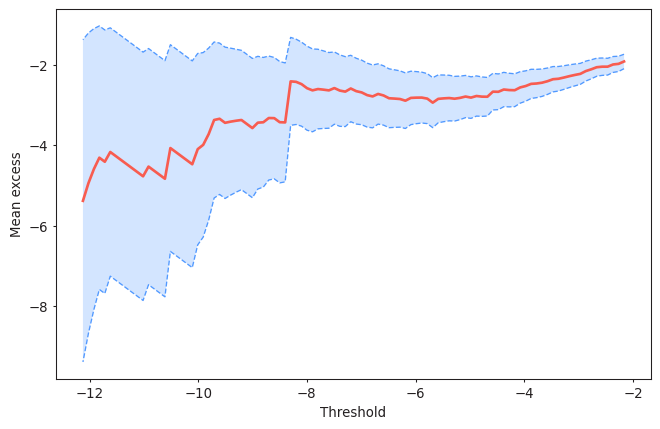

In [109]:
# Plot Mean Residual Life
plot_mean_residual_life(r, alpha=0.95, extremes_type='high')
plot_mean_residual_life(r, alpha=0.95, extremes_type='low')
plt.show()

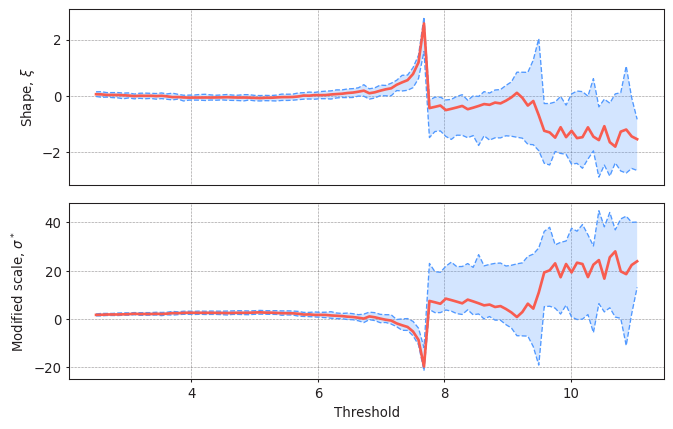

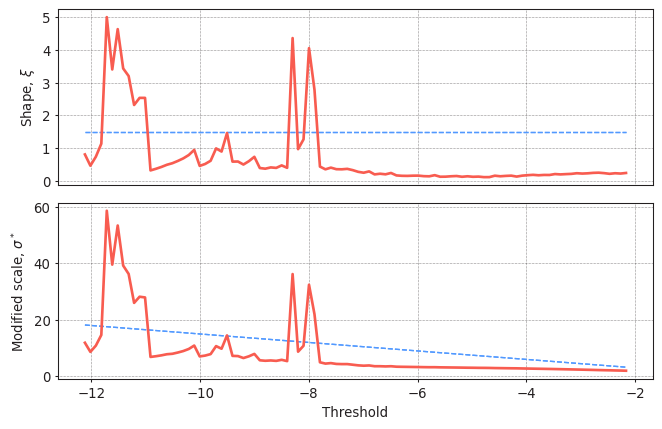

In [131]:
plot_parameter_stability(r, alpha=0.95, extremes_type="high")
plot_parameter_stability(r, alpha=0.95, extremes_type="low")
plt.show()

In [110]:
upper_threshold = 5
lower_threshold = -7.8

### Upper Tail:

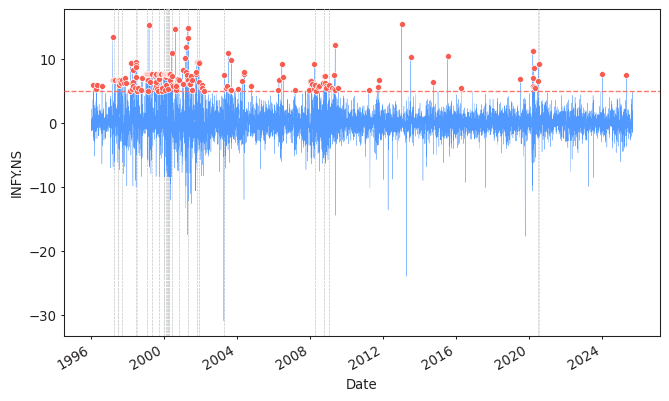

In [114]:
model1 = EVA(data=r)
model1.get_extremes("POT", extremes_type='high', threshold=upper_threshold)
model1.plot_extremes(show_clusters=True)
plt.show()

In [115]:
# Extract exceedances
exceedances_upper = r[r > upper_threshold] - upper_threshold
print("Number of Upper exceedances:", len(exceedances_upper))

# Fit GPD to exceedances
shape_upper, loc_upper, scale_upper = genpareto.fit(exceedances_upper, floc=0)

print("Fitted GPD parameters:")
print(f"Upper: shape={shape_upper:.4f}, loc={loc_upper:.4f}, scale={scale_upper:.4f}")

Number of Upper exceedances: 210
Fitted GPD parameters:
Upper: shape=-0.0869, loc=0.0000, scale=2.2910


In [117]:
model1.fit_model(distribution= "genpareto")
summary = model1.get_summary(
    return_period=[ 5, 10, 25, 50, 100, 250, 500],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value   lower ci   upper ci
return period                                    
5.0               12.050764  10.920361  13.153558
10.0              13.286225  11.860744  14.729138
25.0              14.826672  12.980057  16.888924
50.0              15.925628  13.715211  18.520407
100.0             16.970542  14.357779  20.339061
250.0             18.273404  15.073959  22.627256
500.0             19.202866  15.481809  24.428296


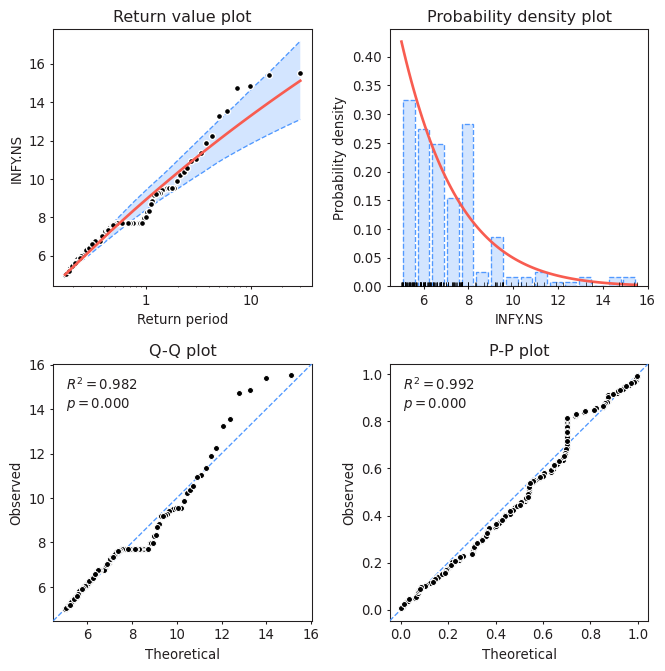

In [118]:
model1.plot_diagnostic(alpha=0.95)
plt.show()

In [126]:
# KS test
ks_statistic, p_value = kstest(exceedances_upper, 'genpareto', args=(shape_upper, 0, scale_upper))
print(f"KS test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# AD test
u = genpareto.cdf(exceedances_upper, c=shape_upper, loc=0, scale=scale_upper)
# Transform to exponential(1)
exp_data = -np.log(u)
# Anderson–Darling test for exponentiality
ad_result = anderson(exp_data, dist='expon')

print("Anderson–Darling test for GPD fit (via PIT)")
print(f"Statistic: {ad_result.statistic:.4f}")
print("Critical values:", ad_result.critical_values)
print("Significance levels:", ad_result.significance_level)

KS test: statistic=0.1347, p-value=0.0009
Anderson–Darling test for GPD fit (via PIT)
Statistic: 2.4111
Critical values: [0.919 1.075 1.337 1.601 1.951]
Significance levels: [15.  10.   5.   2.5  1. ]


### Lower Tail:

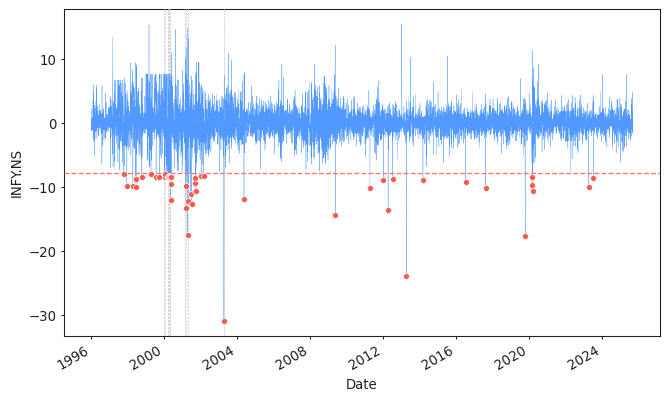

In [120]:
model2 = EVA(data=r)
model2.get_extremes("POT", extremes_type='low', threshold=lower_threshold)
model2.plot_extremes(show_clusters=True)
plt.show()

In [121]:
# Extract exceedances
exceedances_lower = lower_threshold - r[r < lower_threshold]
print("Number of Lower exceedances:", len(exceedances_lower))

# Fit GPD to exceedances
shape_lower, loc_lower, scale_lower = genpareto.fit(exceedances_lower, floc=0)
print("Fitted GPD parameters:")
print(f"Lower: shape={shape_lower:.4f}, loc={loc_lower:.4f}, scale={scale_lower:.4f}")

Number of Lower exceedances: 60
Fitted GPD parameters:
Lower: shape=0.3693, loc=0.0000, scale=1.6635


In [122]:
model2.fit_model(distribution= "genpareto")
summary = model2.get_summary(
    return_period=[ 5, 10, 25, 50, 100, 250, 500],
    alpha=0.95,
    n_samples=1000,
)
print(summary)

               return value   lower ci    upper ci
return period                                     
5.0              -13.489699 -11.498241  -15.920514
10.0             -16.726617 -12.904234  -21.783638
25.0             -22.811005 -14.881361  -36.506843
50.0             -29.318953 -16.606403  -55.510045
100.0            -38.110667 -18.536147  -86.435792
250.0            -54.636328 -20.591047 -163.313953
500.0            -72.312408 -22.181420 -273.176577


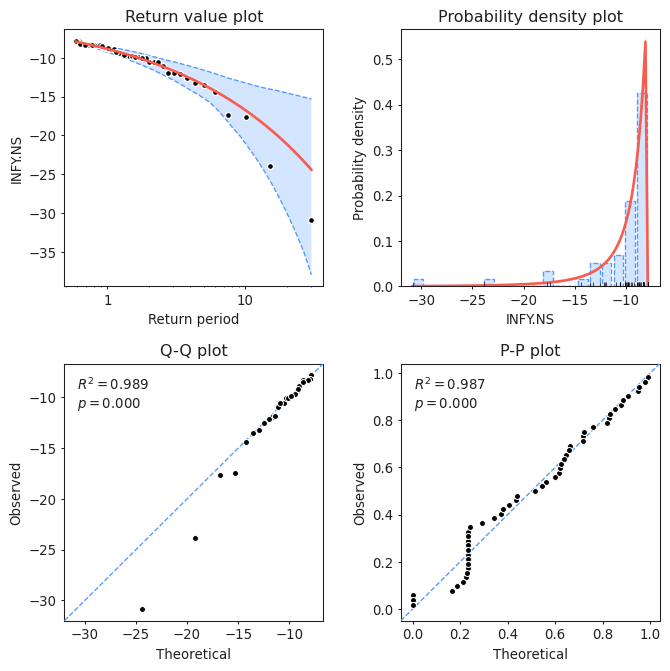

In [123]:
model2.plot_diagnostic(alpha=0.95)
plt.show()

In [125]:
# KS test
ks_statistic, p_value = kstest(exceedances_lower, 'genpareto', args=(shape_lower, 0, scale_lower))
print(f"KS test: statistic={ks_statistic:.4f}, p-value={p_value:.4f}")

# AD test
u = genpareto.cdf(exceedances_lower, c=shape_lower, loc=0, scale=scale_lower)
# Transform to exponential(1)
exp_data = -np.log(u)
# Anderson–Darling test for exponentiality
ad_result = anderson(exp_data, dist='expon')

print("Anderson–Darling test for GPD fit (via PIT)")
print(f"Statistic: {ad_result.statistic:.4f}")
print("Critical values:", ad_result.critical_values)
print("Significance levels:", ad_result.significance_level)

KS test: statistic=0.1449, p-value=0.1458
Anderson–Darling test for GPD fit (via PIT)
Statistic: 1.2848
Critical values: [0.913 1.067 1.328 1.59  1.938]
Significance levels: [15.  10.   5.   2.5  1. ]


# Global PIT (full marginal CDF)

### Smooth CDF: t/Skew-t body and GPD tails with a logistic splice over a short transition band.

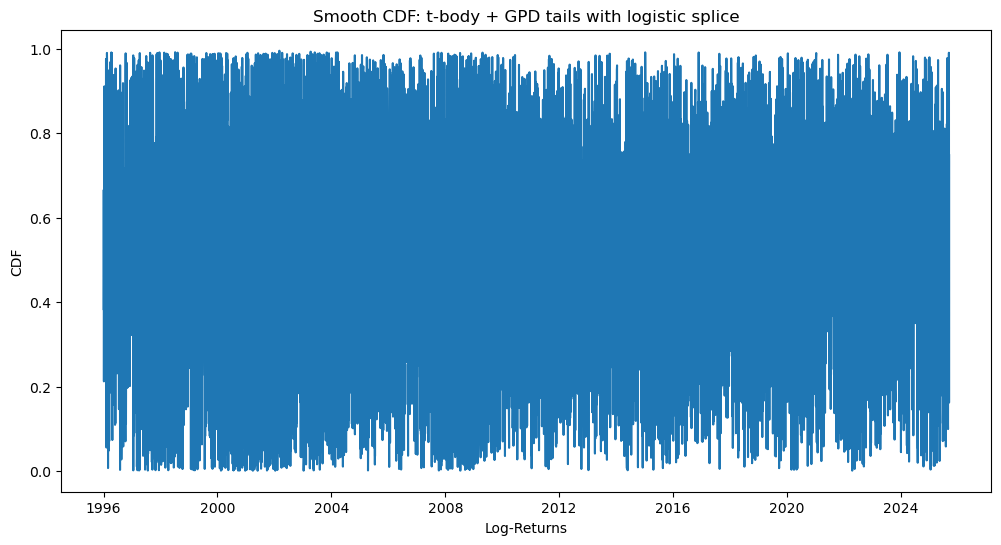

In [128]:
# Small transition width
k = 0.001 * (upper_threshold - lower_threshold)

# Fit body (t-distribution)
df_body, loc_body, scale_body = t.fit(r[(r > lower_threshold) & (r < upper_threshold)])

# Logistic splice
#------define already

# Smooth CDF
#----define already

# Plot
plt.figure(figsize=(12, 6))
plt.plot(r.index, smooth_cdf(r))
plt.xlabel("Log-Returns")
plt.ylabel("CDF")
plt.title("Smooth CDF: t-body + GPD tails with logistic splice")
plt.show()


### PIT values and Histogram

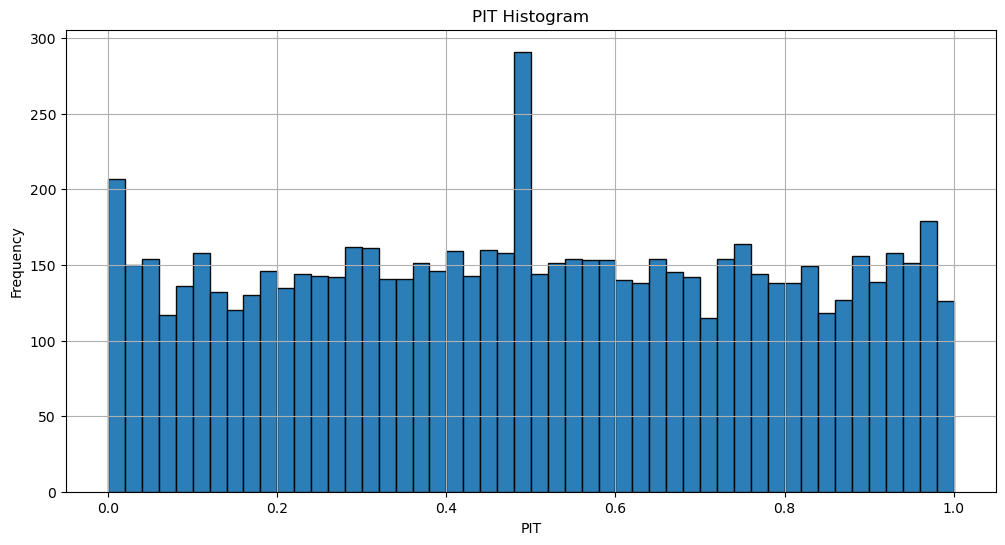

In [129]:
pit_values = smooth_cdf(r.values)
plt.figure(figsize=(12,6))
plt.hist(pit_values, bins=50, range=(0,1), edgecolor='k', alpha=0.95)
plt.xlabel("PIT")
plt.ylabel("Frequency")
plt.title("PIT Histogram")
plt.grid(True)
plt.show()

### KS Test 

In [130]:
ks_stat, p_value = kstest(pit_values, 'uniform')
print(f"KS statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS statistic: 0.0153, p-value: 0.0600
